# Последовательности событий как временные точечные процессы, моделирование с использованием трансформеров

## План

- Определения
- Примеры
- Теоретические задачи
- Синтетические задачи
- Эксперименты на реальных данных

## Определения

### Визуализация временных рядов

Рассмотрим упрощенный сценарий ежедневных поступлений и трат. В начале дня пусть будет поступление зарплаты, процентов, прочих переводов. А во второй половине дня различные траты.

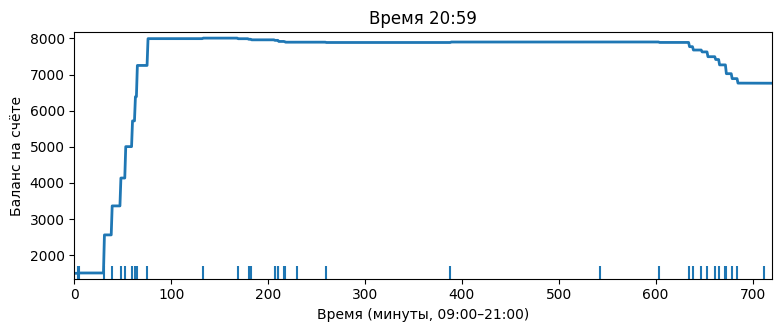

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ---- 1) Простой «банковский день»: мало, но характерных событий
rng = np.random.default_rng(123)
start_min, end_min = 0, 12*60  # 09:00..21:00
t_grid = np.arange(start_min, end_min)

def gaussian(t, mu, sigma, amp):
    return amp * np.exp(-0.5*((t-mu)/sigma)**2)

# Невысокая интенсивность, чтобы событий было немного и понятно
baseline = 0.02 + 0.005*np.sin(2*np.pi*(t_grid/end_min))
payroll = gaussian(t_grid,  45, 20, 0.15)   # утренние начисления зарплаты / проценты по вкладам / прочие поступления
lunch   = gaussian(t_grid, 195, 25, 0.10)   # обеденные траты
bills   = gaussian(t_grid, 660, 30, 0.12)   # вечерние платежи
lam = baseline + payroll + lunch + bills
M = lam.max()

# NHPP (thinning) -> времена транзакций
events, t = [], 0.0
while t < end_min:
    t += rng.exponential(1.0/M)
    if t >= end_min: break
    if rng.random() < lam[min(int(t), end_min-1)]/M:
        events.append(t)
events = np.array(events)
events.sort()

# Суммы транзакций по «окнам» времени (наглядные, без шума)
amounts = np.zeros_like(events)
for i, e in enumerate(events):
    m = int(e)
    if 20 <= m <= 90:        # зарплата
        amounts[i] = rng.normal(800, 120)     # крупные +
    elif 165 <= m <= 225:    # обед
        amounts[i] = -rng.normal(15, 5)       # маленькие -
    elif 630 <= m <= 700:    # вечерние платежи
        amounts[i] = -rng.normal(120, 40)     # средние -
    else:
        amounts[i] = rng.normal(5, 10)        # фон, небольшие +/-

# Классический ряд = баланс как кумулятивная сумма сумм событий
start_balance = 1500.0
balance = np.full_like(t_grid, start_balance, dtype=float)
cum, j = start_balance, 0
for mi, minute in enumerate(t_grid):
    while j < len(events) and events[j] <= minute:
        cum += amounts[j]
        j += 1
    balance[mi] = cum

# ---- 2) Анимация: линия = баланс, тики = события
fig, ax = plt.subplots(figsize=(9, 3.2))
line_balance, = ax.plot([], [], lw=2)
tick_scatter = ax.scatter([], [], marker='|', s=120)

ax.set_xlim(start_min, end_min)
ax.set_ylim(min(balance.min()*0.98, start_balance*0.9), max(balance.max()*1.02, start_balance*1.05))
ax.axhline(0, lw=1, alpha=0.25)
ax.set_xlabel("Время (минуты, 09:00–21:00)")
ax.set_ylabel("Баланс на счёте")
title = ax.set_title("Транзакции (события) → Баланс (классический временной ряд)")

def hhmm(m):
    return f"{9+m//60:02d}:{m%60:02d}"

def label_for_minute(f):
    tags = []
    if 20 <= f <= 90:   tags.append("начисление зарплаты")
    if 165<= f <=225:   tags.append("обеденные траты")
    if 630<= f <=700:   tags.append("вечерние платежи")
    return ", ".join(tags)

def update(frame):
    f = int(frame)
    # линия баланса
    line_balance.set_data(t_grid[:f+1], balance[:f+1])
    # тики событий
    mask = events <= f
    x_ev = events[mask]
    if x_ev.size:
        y0 = ax.get_ylim()[0] + 0.02*(ax.get_ylim()[1]-ax.get_ylim()[0])
        tick_scatter.set_offsets(np.c_[x_ev, np.full_like(x_ev, y0)])
    else:
        tick_scatter.set_offsets(np.empty((0,2)))
    # подписи сюжета
    lab = label_for_minute(f)
    title.set_text(f"Время {hhmm(f)}" + (f" • {lab}" if lab else ""))
    return line_balance, tick_scatter, title

frames = np.linspace(0, end_min-1, 36)  # 36 кадров — плавно и без тяжёлого рендера
anim = FuncAnimation(fig, update, frames=frames, interval=180, blit=True)

HTML(anim.to_jshtml())


Как видно, данный процесс можно рассмотреть с двух сторон. С одной стороны - сумма на счету, которую мы можем наблюдать в любой момент времени. С другой - последовательность событий: поступления и траты, которые уже определны в конкретные моменты времени, когда они произошли. Это приводит нас к сравнению классических временных рядов и последовательностей событий.

### Классические временные ряды

- Плотные
- Одинаковые задержки
- Задачи регрессии
- Примеры:
  - Ежедневная температура в Москве
  - Курс валютной биржи

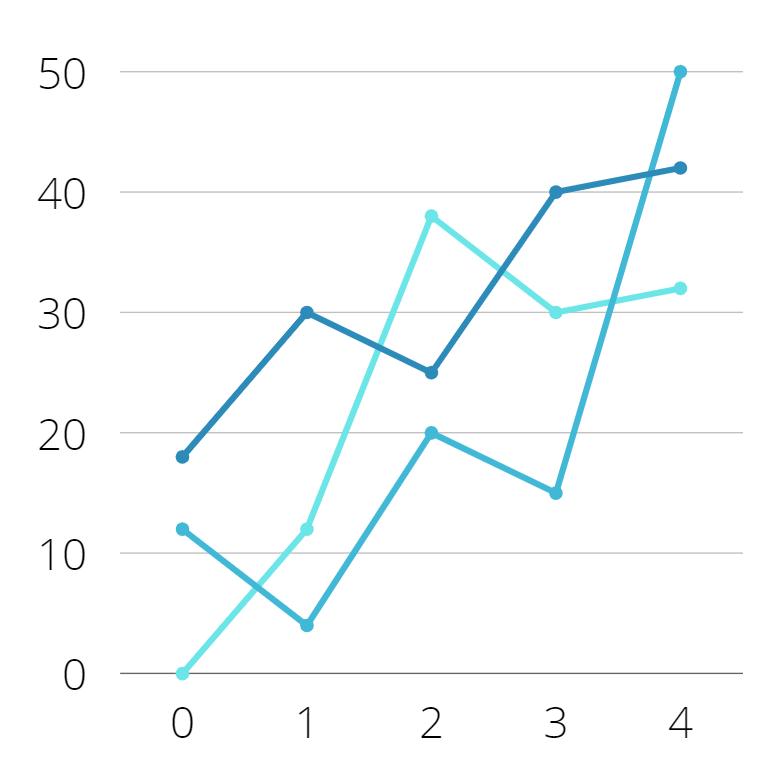

Таким образом, у нас есть некоторое значение, которое мы регулярно наблюдаем, а затем работаем с этими собранными данными. Однако, как мы показали выше, иногда этот подход не применим. Например, банковские транзакции. Они могут происходить несколько раз в день или могут происходить раз в неделю или месяц.

### Точечные процессы в целом

Точечный процесс - это совокупность математических точек, случайно расположенных в математическом пространстве.

Временной точечный процесс - это точечный процесс на временной шкале.

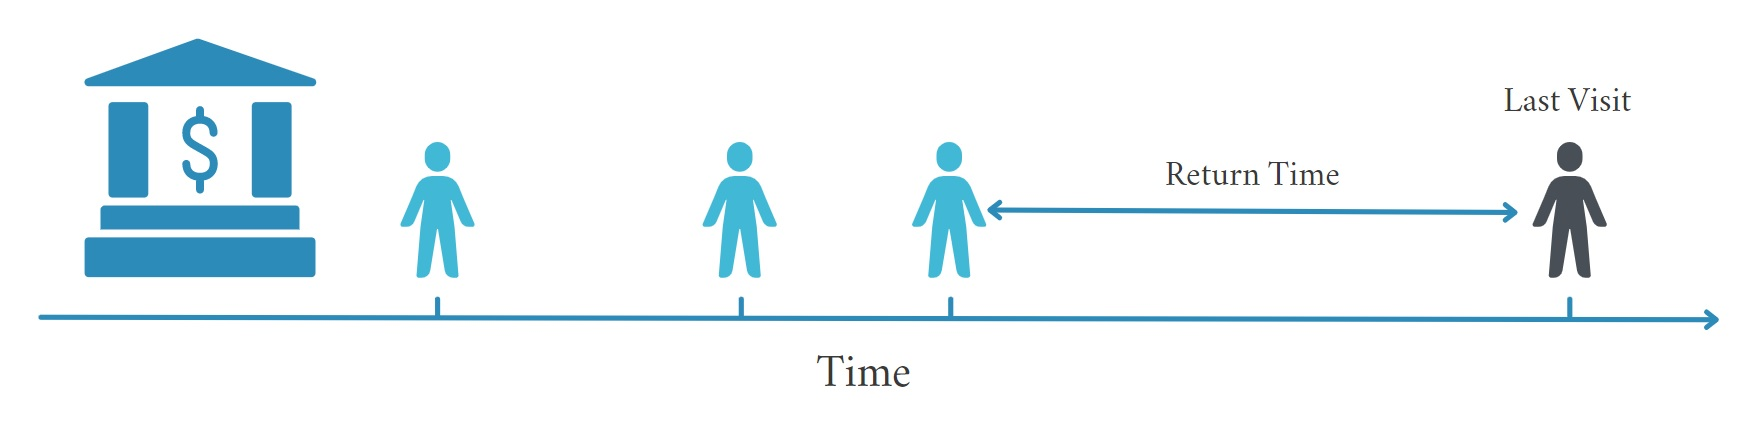

Реализация временного точечного процесса представляет собой последовательность событий $\mathbf{s} = \{(t_i,c_i)\}_{i=1}^N$. Здесь $t_i$ - это момент времени, когда произошло событие, а $c_i\in\mathcal{C}$ - тип события.

Одним из наиболее распространенных способов описания временных точечных процессов является использование функции интенсивности.

$$
\lambda_c(t|\mathcal{H}_t^{\mathcal{C}}) = \frac{\mathbb{E}[dN_c(t|\mathcal{H}_t^{\mathcal{C}})]}{dt} = p(T\in[t;t+dt),C=c|t_i>t)
$$

Эта интенсивность показывает вероятность того, что событие типа $c$ произойдет в полуинтервале $[t;t+dt)$. $N_c(t)$ - это функция подсчета, которая показывает количество событий до момента времени $t$.

### Процесс Пуассона

Процесс Пуассона является самым простым из точечных процессов, который мы можем рассмотреть. В случае процесса Пуассона мы предполагаем, что функция интенсивности не зависит от истории событий.

$$
\lambda_c(t|\mathcal{H}_{t}^{\mathcal{C}}) = \lambda_c(t)
$$

Мы можем рассмотреть **однородный** и **неоднородный** процессы Пуассона. В первом случае предполагается, что нет зависимости от времени, и $\lambda(t) = \lambda$.

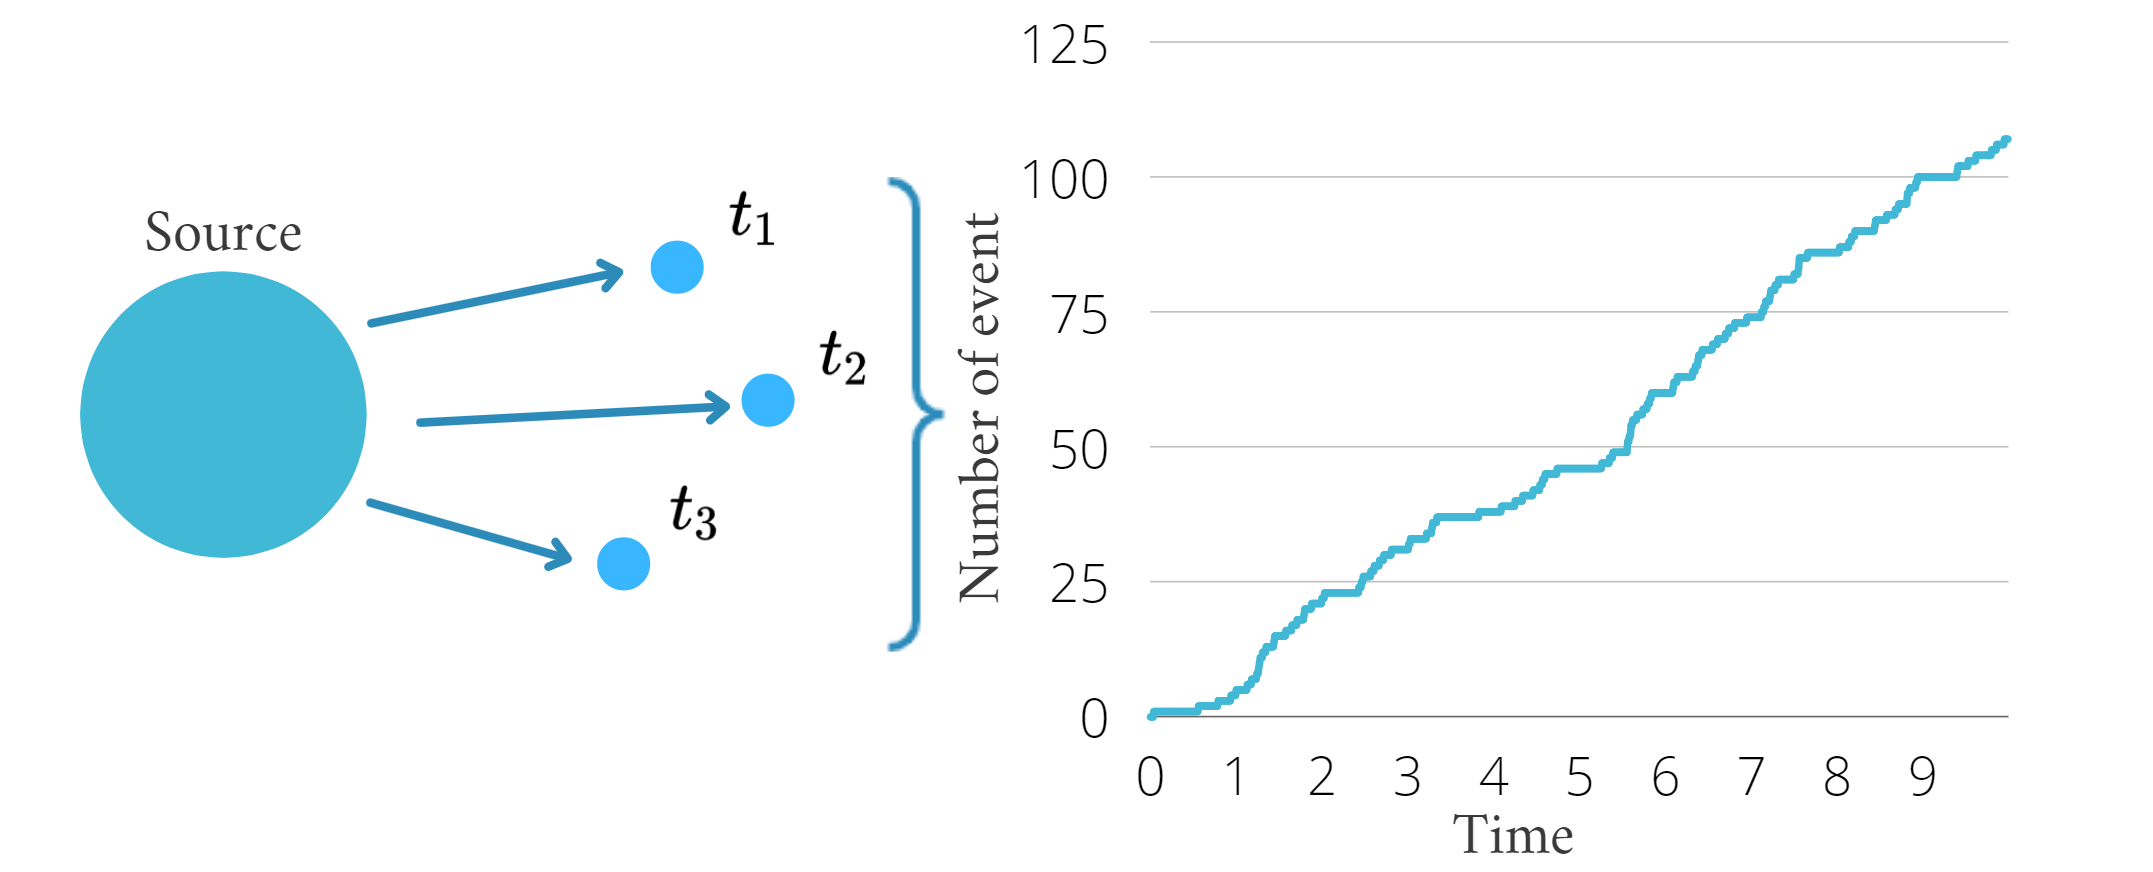

Угловой коэффициент функции подсчета равен интенсивности. Мы проверим этот факт позже в экспериментах.

### Процесс Хоукса

Впервые процессы Хокса были представлены в 1971 году, и в оригинальной работе использовались экспоненциальные ядра.

**Предположения**

- История влияет на интенсивность.
- Процесс самовозбуждающийся, воздействия неотрицательны.
- Воздействия аддитивны.

Функция интенсивности $\lambda_c(t|\mathcal{H}_t^{\mathcal{C}}) = \mu_c(t) + \sum_{i:t_i<t}\phi_{c,c_i}(t-t_i)$.

**Обозначения:**

- $\mu_c(t)$ - базовая интенсивность, не зависящая от истории.
- $\phi_{c,c'}(s), c,c'\in\mathcal{C}$ - ядра, показывающие, как событие типа $c'$ влияет на интенсивность события типа $c$.

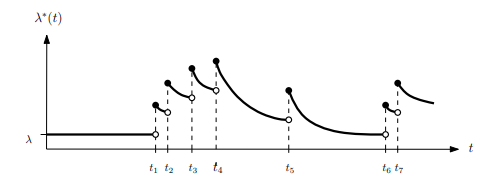

### Интерактивная песочница

Попробуйте «поиграть» со скоростью базового потока и самовозбуждением, посмотрите на различия между пуассоновским процессом и процессом Хоукса.

In [ ]:
import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as W

@dataclass
class HawkesParams:
    mu: float   # базовая интенсивность
    a: float    # амплитуда самовозбуждения
    b: float    # спад экспоненты (>0)

def simulate_poisson_T(mu, T, rng, first_time=None):
    times = []
    t = first_time or (-math.log(1.0 - rng.random()) / mu)
    while t < T:
        times.append(t)
        t += -math.log(1.0 - rng.random()) / mu
    return np.array(times)

def ogata_hawkes(mu, a, b, T, rng, first_time=None):
    events = []
    t = 0.0
    lam = mu
    # если хотим совпадение первого события — добавляем заранее
    if first_time is not None:
        events.append(first_time)
        t = first_time
        lam = mu + a  # сразу добавляем эффект
    while True:
        M = max(lam, mu + (a * np.sum(np.exp(-b*(t - np.array(events))))) if events else mu + a)
        t += -math.log(rng.random())/M
        if t > T:
            break
        lam_t = mu + np.sum(a*np.exp(-b*(t - np.array(events)))) if events else mu
        if rng.random() <= lam_t/M:
            events.append(t)
            lam = lam_t + a
        else:
            lam = lam_t
    return np.array(events)

def plot_timeline(times, T, title="События"):
    fig, ax = plt.subplots(figsize=(8, 1.6))
    ax.scatter(times, np.zeros_like(times), marker='|', s=400)
    ax.set_xlim(0, T)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel("time")
    plt.show()

T = 50.0

def play(mu=0.2, a=0.4, b=1.0, kind="poisson"):
    clear_output(wait=True)
    rng = np.random.default_rng(42)
    # генерируем одно и то же первое событие
    first_event = -math.log(1.0 - rng.random()) / mu
    if kind == "poisson":
        ts = simulate_poisson_T(mu, T, rng, first_time=first_event)
        plot_timeline(ts, T, title=f"Poisson(mu={mu})")
    else:
        ts = ogata_hawkes(mu, a, b, T, rng, first_time=first_event)
        plot_timeline(ts, T, title=f"Hawkes(mu={mu}, a={a}, b={b})")

kind = W.ToggleButtons(options=[("Poisson","poisson"),("Hawkes","hawkes")], description="Процесс:")
mu = W.FloatLogSlider(value=0.2, base=10, min=-2, max=1, step=0.01, description='mu')
a = W.FloatSlider(value=0.4, min=0.0, max=1.5, step=0.05, description='a')
b = W.FloatLogSlider(value=1.0, base=10, min=-2, max=2, step=0.01, description='b')

ui = W.VBox([kind, mu, a, b])
out = W.interactive_output(play, {'mu': mu, 'a': a, 'b': b, 'kind': kind})
display(ui, out)


Output()

#### Наблюдение: взрывной характер при `a > b`

Попробуйте задать параметрам значения  
`μ = 0.2`, `a = 1.0`, `b = 0.5`  
и посмотрите, как изменяется структура событий.  

Вы заметите, что события начинают **«цепляться» друг за друга** — каждое рождает последующие, интервалы между событиями быстро сокращаются, а интенсивность λ(t) растёт почти лавинообразно.  

Это проявление **взрывного (supercritical)** характера процесса Хоукса.

#### Почему так происходит?

Для экспоненциального ядра  
$$
\lambda(t) = \mu + \sum_{t_i < t} a \, e^{-b (t - t_i)}
$$
параметр `a` определяет *силу самовозбуждения*,  
а `b` — *скорость затухания эффекта предыдущего события*.

Если каждое событие в среднем порождает **меньше одного** «потомка», процесс остаётся стабильным (stationary).  
Если же **больше одного** — интенсивность растёт без ограничений, и процесс может «взорваться».

#### Branching ratio (коэффициент ветвления)

Для экспоненциального ядра коэффициент ветвления равен:
$$
n = \frac{a}{b}.
$$

- Если **n < 1**, процесс *subcritical*: события постепенно угасают, и интенсивность колеблется вокруг стационарного уровня.  
- Если **n = 1**, процесс *critical*: система на грани самоподдерживающегося роста.  
- Если **n > 1**, процесс *supercritical*: каждое событие порождает в среднем >1 «потомка» → лавинообразное размножение событий.

#### Интерпретация в банковском контексте

Если рассматривать события как, например, **реакции клиентов**  
(массовые переводы, снятия, транзакции после уведомлений),  
то при `a/b > 1` система моделирует **самоусиливающийся кризис**.


### Нейросетевые модели

#### Классический временной ряд

В основном данные синхронны, с одинаковой задержкой

Данные могут быть представлены в виде последовательности значений $\{\mathbf{x}_i\}_{i=1}^N$I c заданным временным лагом $\Delta t$.

Нейронные сети:
- Рекуррентные нейронные сети (RNN, LSTM, GRU)
    
     Плюсы:
    
     - Улавливают временные зависимости
    
     Минусы:
    
     - Стремление поймать долгосрочные зависимости
     - Борьба с исчезновением градиента
     - Не могут быть распараллеленны

- CNN для временных рядов
    
     Плюсы:
    
     - Могут быть распараллеленны
     - Лучше фиксирует долгосрочные зависимости
    
     Минусы:
    
     - Принудительно применяют ненужные зависимости

- Трансформеры
    
     Плюсы:
    
     - Могут быть распараллеленны
     - Изучают внутренние зависимости с помощью механизма внимания

#### Последовательности событий

Данные асинхронны, неодинаково запаздывают

Данные могут быть представлены в виде последовательности пар $\{(t_i,c_i)\}_{i=1}^N$, временной лаг предусмотреть нельзя и нужно учитывать время прихода.

Нейронные сети:

Должно быть похоже, однако, как можно учитывать неравные лаги?

#### Общий порядок обучения

Предположим, что мы успешно построили некоторую модель  
$$
model(\mathbf{s}) \to \lambda(t|\mathcal{H})
$$
описывающую интенсивность событий во времени.  
Как мы можем её обучать?

##### Функция потерь — отрицательная логарифмическая вероятность

$$
\mathcal{L} = -\sum_{n=1}^N\left(\sum_{i=1}^{L_n}\log \lambda_{i}^n - \int_{0}^{T_n}\lambda(t | \mathcal {H} _n)\,dt \right)
$$

Наша цель — **минимизировать** эту функцию потерь.

##### Что делать с интегралом?

**Интеграция Монте-Карло**

$$
\hat{\Lambda}_{MC} = \sum_{j=2}^L (t_j - t_{j-1})
\left( \frac{1}{N} \sum_{i=1}^N \lambda(u_i) \right),
\quad u_i \sim \mathrm{Unif}(t_{j-1}, t_j)
$$

Интеграция по методу **Монте-Карло** даёт *несмещённую оценку* (unbiased estimator) интеграла,  
что критически важно для **градиентного спуска** — в среднем градиент направлен точно в сторону истинного минимума,  
а стохастичность лишь добавляет шум, не искажающий направление оптимизации.

**Трапециевидная интеграция**
$$
\hat{\Lambda}_{TR} = \sum_{j=2}^L \frac{t_j - t_{j-1}}{2}
\left( \lambda(t_j|\mathcal{H}_{t_j}) + \lambda(t_{j-1}|\mathcal{H}_{t_{j-1}}) \right)
$$

Трапециевидное приближение **быстрее**, но даёт **систематическую ошибку (смещение)**,  
что может приводить к неточным градиентам и замедлению сходимости.

##### Вывод

- **Monte Carlo** — медленнее, но даёт *unbiased* градиенты → корректное обучение.  
- **Трапеции** — быстрее, но *biased* → риск искажения направления оптимизации.

Теперь у нас есть корректно определённая целевая функция.  
Далее — разработка модели, способной аппроксимировать $\lambda(t | \mathcal{H})$.


#### Нейронный процесса Хоукса

https://www.researchgate.net/publication/312022942_The_Neural_Hawkes_Process_A_Neurally_Self-Modulating_Multivariate_Point_Process

Эта работа была вдохновлена моделью LSTM. Модель LSTM оказалась хорошим выбором для прогнозирования временных рядов.

**Вопрос:**
Как мы можем применить LSTM к последовательностям событий?

Основная проблема здесь в том, что LSTM был разработан для данных с равной задержкой.
В статье авторы предложили добавить эволюцию скрытых и клеточных состояний между событиями.

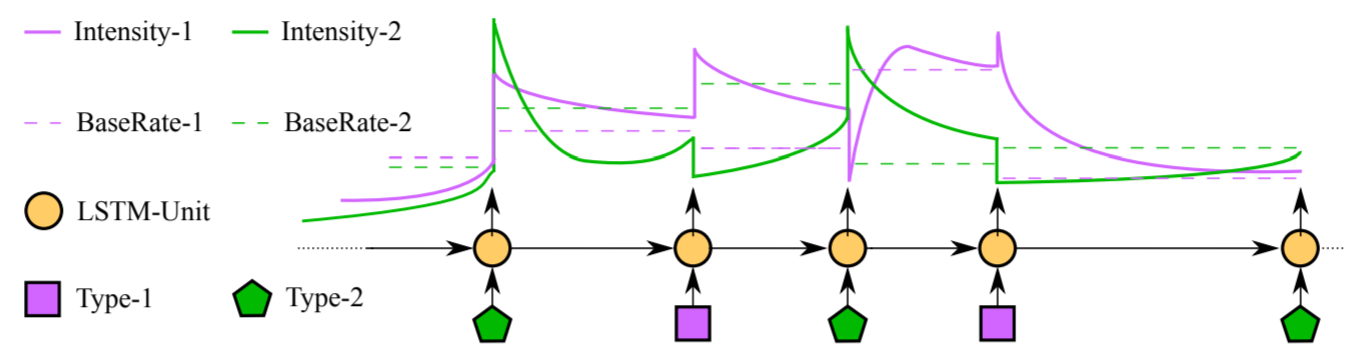

Интенсивности можно найти со скрытым состоянием, используя следующую формулу:
$$\lambda_k(t) = f_k(\mathbf{w}_k^\top \mathbf{h}(t)), ~ f_k(u) = s_k \log(1 + \exp(u/s_k))$$

Здесь k — тип события, а $f_k$ гарантирует, что результат будет больше нуля.

Архитектура LSTM аналогична исходной архитектуре LSTM, поэтому мы не будем на ней сосредотачиваться.


Давайте изучим, как именно устроена эволюция между событиями.

- Скрытое состояние зависит от состояния ячейки $\mathbf{h}(t) = \mathbf{o}_i \odot ( 2\sigma(2\mathbf{c}(t)) - 1)$
- Состояния ячеек эволюционируют в некоторое базовое состояние ячейки $\mathbf{c}(t) = \overline{\mathbf{c}}_{i+1} + (\mathbf{c}_{i+1} - \overline {\mathbf{c}}_{i+1})\exp(-\boldsymbol{\delta}_{i+1}(tt_i))$
- Если мы забудем о нелинейностях, окажется, что мы используем показатели степени в качестве базисных функций.
- Нелинейности позволяют добиться более сложного поведения
- Мы можем предсказать волнения, возбуждения и их комбинации

Посмотрим на функци. интенсивности:

$$\lambda_k(t) = g(\{(c_{i+1}^j - \overline{c}_{i+1}^j)\exp(-\delta_{i+1}^j(t-t_i)\}_{j=1}^{hidden\_size})$$

Здесь $g$ — функция, объединяющая все функции $\lambda_k$. Это позволяет нам прогнозировать огромное разнообразие моделей поведения.

- Плюсы
     - Моделирует функцию интенсивности везде
     - Учитывает неравные временные задержки
- Минусы
    
     - То же, что и для классического LSTM

#### Трансформер Хоукса

https://arxiv.org/pdf/2002.09291.pdf

- Трансформер - это современное решение для задач seq2seq.
- Трансформеры могут эффективно улавливать долгосрочные зависимости
- Трансформаторы могут быть параллельны
- Они не предназначены для временных точечных процессов...

Можно использовать эмбеддинги для типов событий, и оно будет работать с преобразователями. Но что нам делать со временем прибытия?

**Решение**

Временное кодирование $(i\in\{1,\dots,M\})$

$$
[\mathbf{z}(t_j)]_i = \begin{cases}cos(t_j/10000^{\frac{i-1}{M}}), ~ \text{if} ~ i~\text{is odd}\\sin(t_j/10000^{i/M}), ~ \text{if} ~ i~\text{is even}\end{cases}
$$

Кодирование событий

$$
\mathbf{e}_j = \mathbf{U}\mathbf{c}_j
$$

$\mathbf{c}_j$ is an event one-hot encoding, $\mathbf{U}\in\mathbb{R}^{M\times C}$. $\mathbf{C} = [\mathbf{c}_1,\dots,\mathbf{c}_L]\in\mathbb{R}^{K\times L}$

Вход трансформатора будет следующим:

$$
\mathbf{X} = (\mathbf{U}\mathbf{C} + \mathbf{Z})^{\top}
$$


**Архитектура**

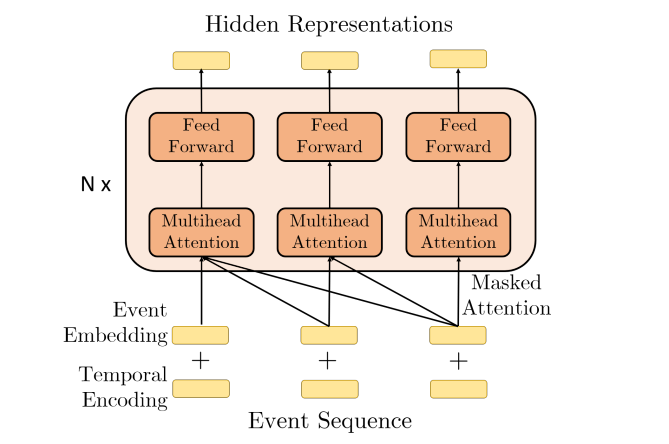

**Напоминание**
    
Механизм внимания:
    
$$
    \mathbf{S} = \mathrm{Softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{M_K}}\right)\mathbf{V}
$$
    
$$
    \mathbf{Q} = \mathbf{X}\mathbf{W}^Q,~\mathbf{K} =\mathbf{X}\mathbf{W}^K,~\mathbf{V}=\mathbf{X}\mathbf{W}^V
$$
    
$$
    \mathbf{W}^Q,\mathbf{W}^K\in\mathbb{R}^{M\times M_{K}},~\mathbf{W}^V\in \mathbb{R}^{M\times M_V}
$$
    
Multihead Attention: $\mathbf{S}_1,\dots,\mathbf{S}_H$.
    
Выход мезанизма внимания:
    
$$
    \mathbf{S} = [\mathbf{S}_1,\dots,\mathbf{S}_H]\mathbf{W}^O, ~ \mathbf{W}^O\in\mathbb{R}^{HM_V\times M}
$$
    
За механизмом вниманя следует нейронная сеть с прямой связью по положению, состоящая из двух линейных слоев. Результирующая матрица$\mathbf{H}\in\mathbb{R}^{L\times M}$.
    
Авторы избегают заглядывания в будущее, используя маскированное внимание.

Теперь, когда мы успешно внедрили модель трансформера, которая может обрабатывать последовательности событий, как мы можем предсказать интенсивность?

В статье авторы предложили следующее решение:

$$
\lambda_k(t|\mathcal{H}_t) = f_k\left(\alpha_k\frac{t-t_j}{t_j} + \mathbf{w}_k^{\top}\mathbf{h}(t_j) + b_k\right),~t\in[t_j,t_{j+1})\\f_k(u) = s_k\log(1+\exp(u/s_k))
$$

Условия:

- $\alpha_k\frac{t-t_j}{t_j}$ - интерполяция текущего влияния между наблюдаемыми временными метками $t_j$ и $t_{j+1}$
- $\mathbf{w}_k^{\top}\mathbf{h}(t_j)$ - исторический термин
- $b_k$ - базовая интенсивность

Учитывая эту интенсивность, можно найти ожидаемое время прибытия и тип события следующим образом:

$$
p(t|\mathcal{H}_t) = \lambda(t|\mathcal{H}_t)\exp\left(-\int_{t_j}^t\lambda(\tau|\mathcal{H}_{\tau})d\tau\right)\\\hat{t}_{j+1} = \int_{t_j}^{+\infty}tp(t|\mathcal{H}_t)dt\\ \hat{c}_{j+1} = \arg\max_c \frac{\lambda_c(t_{j+1}|\mathcal{H}_{j+1})}{\lambda(t_{j+1}|\mathcal{H}_{j+1})}
$$

## Примеры

### Вопрос: Какие реальные процессы можно описать с помощью модели Пуассона?


- Приход клиентов в очередь (например, в банке или супермаркете)  
- Отказы машин или серверов  
- Поток автомобилей на перекрёстке  
- Падение космических частиц  

Во всех этих случаях события происходят **во времени**.  
Процесс Пуассона предполагает, что:

1. События происходят **независимо** друг от друга.  
2. Вероятность появления нового события **не зависит** от времени, прошедшего с последнего.  
3. Интенсивность $\lambda(t)$ — **постоянна** (или, в простейшем случае, слабо меняется со временем).  


### Пример с очередью


#### Вопрос: Предположим, у нас есть кассир и очередь. Мы можем описать это как два точечных процесса - приход людей и обслуживание людей. Какой из процессов мы можем описать как процесс Пуассона?



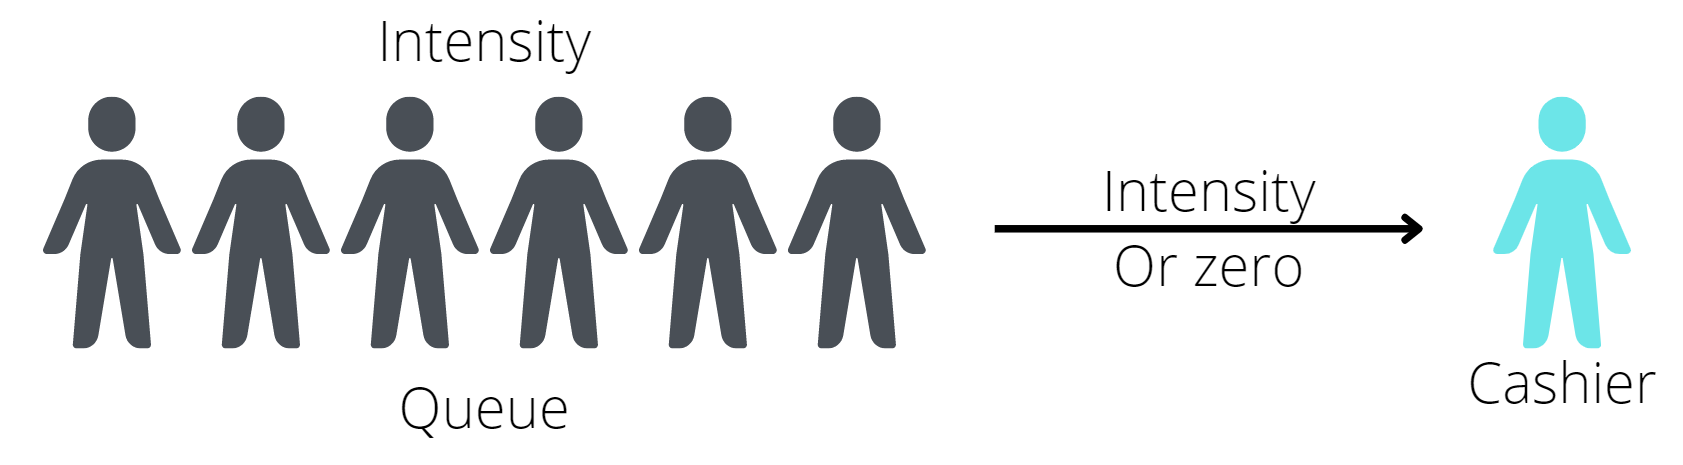

Представим, что клиенты приходят к кассиру случайно.  
Поток прихода можно описать процессом Пуассона с интенсивностью $\lambda_a$:

$$
N_a(t) \sim \text{Poisson}(\lambda_a t)
$$

Кассир обслуживает клиентов тоже случайно — с интенсивностью $\lambda_s$.

Но если **очередь пуста**, обслуживать некого:

$$
\lambda_s(t) =
\begin{cases}
\lambda_s, & \text{если очередь непуста},\\[6pt]
0, & \text{если очередь пуста.}
\end{cases}
$$

Здесь мы сталкиваемся с ограничением модели Пуассона:
- процесс **не может учитывать состояние системы** (наличие очереди);
- интенсивность по определению не должна зависеть от истории.  

Таким образом, процесс Пуассона корректно описывает **приход людей**,  
но уже не описывает **обслуживание**, которое зависит от предыдущих событий.

In [ ]:
# Интерактивная визуализация очереди M/M/1: λ (arrival rate) vs μ (service rate)
# Работает в Jupyter/Colab. Ничего устанавливать не нужно.

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as W

def simulate_mm1(lam=0.6, mu=1.0, T=60.0, seed=0):
    """
    Дискретно-событийная симуляция M/M/1 до времени T.
    Возвращает:
      times  — точки переключений,
      qlens  — длина очереди на полуинтервале [times[i], times[i+1]),
      idle_frac — доля времени с пустой очередью,
      mean_q   — средняя длина очереди (временное среднее)
    """
    rng = np.random.default_rng(seed)
    t = 0.0
    q = 0
    times = [0.0]
    qlens = [0]

    # планируем первое прибытие и окончание обслуживания
    t_arr = rng.exponential(1.0/lam)
    t_dep = np.inf  # нет обслуживания, пока нет клиентов

    idle_time = 0.0
    last_t = 0.0
    area_q = 0.0

    while t < T:
        # следующий ивент
        if t_arr < t_dep:
            t_next = t_arr
            event = 'arrival'
        else:
            t_next = t_dep
            event = 'departure'

        if t_next > T:
            # доходим до T и выходим
            area_q += q * (T - t)
            if q == 0:
                idle_time += (T - t)
            t = T
            break

        # накапливаем интегралы по участку [t, t_next)
        area_q += q * (t_next - t)
        if q == 0:
            idle_time += (t_next - t)

        # переходим во времени
        t = t_next

        # событие
        if event == 'arrival':
            q += 1
            t_arr = t + rng.exponential(1.0/lam)
            # если раньше не обслуживали, стартуем обслуживание
            if q == 1:
                t_dep = t + rng.exponential(1.0/mu)
        else:  # departure
            q = max(0, q-1)
            if q > 0:
                t_dep = t + rng.exponential(1.0/mu)
            else:
                t_dep = np.inf

        # фиксируем ступень
        times.append(t)
        qlens.append(q)

    # гарантируем финальную точку
    if times[-1] < T:
        times.append(T)
        qlens.append(qlens[-1])

    idle_frac = idle_time / T
    mean_q = area_q / T
    return np.array(times), np.array(qlens), idle_frac, mean_q

def plot_mm1(lam=0.6, mu=1.0, T=60.0, seed=0):
    times, qlens, idle_frac, mean_q = simulate_mm1(lam, mu, T, seed)

    rho = lam / mu if mu > 0 else np.inf
    theo_idle = max(0.0, 1.0 - rho) if rho < 1 else 0.0

    fig, ax = plt.subplots(figsize=(9, 3.6))
    # лестничный график длины очереди
    ax.step(times, qlens, where='post', linewidth=2)

    # Подсветим интервалы пустоты (q==0)
    for i in range(len(times)-1):
        if qlens[i] == 0:
            ax.axvspan(times[i], times[i+1], color='lightgrey', alpha=0.5)

    ax.set_xlim(0, T)
    ax.set_ylim(0, max(3, qlens.max()+1))
    ax.set_xlabel("Время")
    ax.set_ylabel("Длина очереди")
    ax.set_title("Очередь M/M/1: пустые интервалы закрашены")

    # Аннотации со сводкой
    text = [
        rf"$\lambda$ (приход) = {lam:.2f}",
        rf"$\mu$ (обслуживание) = {mu:.2f}",
        rf"$\rho=\lambda/\mu$ = {rho:.2f}",
        rf"Доля пустого времени (эмп.) = {idle_frac:.2f}",
        rf"$P_0$ теор. = {theo_idle:.2f}" + ("  (ρ<1)" if rho < 1 else "  (ρ≥1, стац. нет)"),
        rf"Средняя длина очереди (эмп.) = {mean_q:.2f}",
    ]
    ax.text(1.02, 0.95, "\n".join(text), transform=ax.transAxes,
            va='top', ha='left', fontsize=10, family='monospace')

    # Подписи-инсайты
    if mu > lam:
        ax.text(0.02, 0.9, "μ > λ → очередь часто пуста", transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="white", ec="0.7"))
    elif mu < lam:
        ax.text(0.02, 0.9, "μ < λ → очередь почти не пустеет", transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="white", ec="0.7"))
    else:
        ax.text(0.02, 0.9, "μ ≈ λ → на грани: редкие пустоты", transform=ax.transAxes,
                bbox=dict(boxstyle="round", fc="white", ec="0.7"))

    plt.show()

# Виджеты
W.interact(
    plot_mm1,
    lam=W.FloatSlider(value=0.6, min=0.1, max=2.0, step=0.05, description='λ приход'),
    mu =W.FloatSlider(value=1.0, min=0.1, max=2.5, step=0.05, description='μ кассир'),
    T  =W.FloatSlider(value=60.0, min=20.0, max=240.0, step=10.0, description='Горизонт T'),
    seed=W.IntSlider(value=0, min=0, max=10, step=1, description='seed')
);


interactive(children=(FloatSlider(value=0.6, description='λ приход', max=2.0, min=0.1, step=0.05), FloatSlider…

На графике мы видим динамику длины очереди во времени.  
Закрашенные серым участки показывают **периоды, когда очередь пуста** — кассир простаивает.

- При **$\mu > \lambda$**  
  кассир обслуживает клиентов **быстрее**, чем они приходят.  
  В среднем обслуживание «опережает» поток,  
  поэтому система часто возвращается в состояние $Q(t) = 0$.  
  Теоретически вероятность пустоты равна:
  $$
  P_0 = 1 - \rho, \quad \text{где} \quad \rho = \frac{\lambda}{\mu}.
  $$
  Чем больше запас по скорости обслуживания, тем чаще встречаются пустые промежутки.

- При **$\mu < \lambda$**  
  клиенты приходят **быстрее**, чем кассир успевает их обслуживать.  
  Очередь растёт, и вероятность состояния $Q(t)=0$ стремится к нулю.  
  Система перегружена, и пустые интервалы почти не встречаются.

### Пример с отказом машин

Для прогнозирования отказов машин мы можем начать с простого процесса Пуассона, предполагая, что отказы происходят случайно. Этот метод прост и полезен, когда у нас нет подробных данных.

Для более точных прогнозов мы можем использовать модель пропорциональных рисков Кокса. Эта модель, лучше подходящая для анализа выживаемости, учитывает дополнительные переменные, такие как возраст машины и история обслуживания, предлагая более тонкий прогноз.

Формула
$$\lambda_{PH} = \lambda_0(t) \exp(-x^\top \beta)$$
в модели Кокса отражает, как эти переменные влияют на риск отказа со временем. Если подробные данные недоступны, процесс Пуассона служит базовой, начальной моделью.

### Вопрос: Можете ли вы предложить примеры реальных задач, где мы ожидаем, что процесс будет являться процессом Хокса?



1. Динамика ретвитов в социальных сетях, например, в Twitter. Когда кто-то делает ретвит, это увеличивает вероятность дополнительных действий, таких как лайки или комментарии. Однако со временем эта вероятность уменьшается. Исследование на эту тему: [Retweet Dynamics (Koboyashi et.al. 2016)](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM16/paper/view/13026/12739).

2. Динамика фьючерсных контрактов на финансовом рынке. В этой сфере активность одного участника рынка может повышать вероятность реакций других участников. Ссылка на исследование: [Financial Market Futures Contracts (Hardiman et.al. 2013)](https://link.springer.com/content/pdf/10.1140/epjb/e2013-40107-3.pdf).

3. Распространение Covid-19. Процесс Хокса может описывать, как инфекция передается от одного человека к другому, увеличивая вероятность новых случаев заражения после каждого зарегистрированного случая. Соответствующее исследование: [Covid-19 Spread (Garetto et.al. 2021)](https://www.sciencedirect.com/science/article/pii/S1367578821000080).

Эти примеры демонстрируют, как процесс Хокса может быть применен для моделирования событий, где одно событие повышает вероятность следующего в течение определенного времени, создавая своеобразную цепную реакцию.

### Резюме примеров

- Зависимости в последовательностях событий обычно сложнее простого процесса Пуассона.
- Процесс Пуассона представляет собой хорошее начальное приближение.
- Многие локальные задачи могут быть смоделированы с использованием модели процесса Пуассона.
- Процесс Хоукса является эффективным следующим этапом в моделировании, позволяющим успешно описывать реальные проблемы с учетом более сложных взаимосвязей в последовательностях событий.
- Использование нейронных сетей может дополнительно улучшить моделирование, внося способность обучения и адаптации к сложным шаблонам данных, что особенно полезно в сценариях с большим объемом и высокой изменчивостью данных.

## Теоретические Задачи

### Распределение Пуассона

#### Вопрос: Что такое Распределение Пуассона?



Это дискретное вероятностное распределение с следующей функцией массы вероятности (PMF):

$$ p(k) = \frac{\lambda^k e^{-\lambda}}{k!} $$

где $ k \in \mathbb{Z}_{0+}$.



#### Вопрос: Как связано Распределение Пуассона с Процессом Пуассона?



Функция подсчета событий в Процессе Пуассона может быть описана с помощью Распределения Пуассона.

Рассмотрим Однородный Процесс Пуассона с функцией интенсивности $ \lambda(t) = \lambda $. В этом случае:

$$ p(N(t) = k) = \frac{(\lambda t)^k e^{-\lambda t}}{k!} $$

Позднее мы также покажем, что Распределение Пуассона связано и с Неоднородным Процессом Пуассона.

### Функции для Пуассоновского процесса

#### Вопрос: Какие функции могут быть использованы, чтобы описать точечный процесс?


- Интенсивность
- Плотность вероятности
- Функция выживания

#### Задача: Показать, используя определения, как все функции связаны друг с другом, исходя из функции интенсивности $ \lambda(t) $.

Пусть T - это случайная величина времени прибытия.

Исходя из определений:

- Функция интенсивности: $ \lambda(t) dt = p(T \in [t; t+dt) | T \geq t) $
- Функция плотности вероятности: $ f(t) dt = p(T \in [t; t+dt)) $
- Функция выживания: $ S(t) = p(T \geq t) $

$$
\lambda(t) = p(T \in [t; t+dt) | T \geq t) = \frac{p(T \geq t | T \in [t; t+dt)) \cdot p(T \in [t; t+dt))}{p(T \geq t)} = \frac{1 \times p(T \in [t; t+dt))}{p(T \geq t)} = \frac{f(t)}{S(t)}
$$

$$
S(t) = p(T \geq t) = \int_{t}^{+\infty} f(z) dz
$$
$$
\frac{dS(t)}{dt} = -f(t)
$$

Теперь найдем функцию выживания, решая следующее дифференциальное уравнение:

$$
\frac{dS}{dt} = -S \lambda(t)
$$
$$
\frac{dS}{S} = -\lambda(t) dt
$$
$$
S(t) = Ce^{-\int_{0}^t \lambda(z) dz}
$$

Константу можно найти из условия, что $ S(0) = 1 $, так что $ C = 1 $.

Таким образом, функция плотности вероятности может быть записана следующим образом:
$$
f(t) = \lambda(t) e^{-\int_{0}^{t} \lambda(z) dz}
$$

**Итог:**
- $ \lambda(t) = \frac{f(t)}{S(t)} $
- $ f(t) = \lambda(t) e^{-\int_{0}^t \lambda(z) dz} $
- $ S(t) = e^{-\int_{0}^t \lambda(z) dz} $

### Правдоподобие

#### Вопрос: Как мы можем оптимизировать модель, когда работаем со стохастическим процессом?

Мы должны максимизировать правдоподобие - плотность вероятности датасета относительно параметров модели по этим параметрам.

#### Задача: Дан временной точечный процесс и его функции интенсивности $\lambda_c(t),~c\in\mathcal{C}$, и последовательность событий $s$, найти функцию плотности вероятности для этой последовательности событий $p_{\lambda}(s)$.

*Подсказка: Используйте правило цепи и найдите плотность вероятности для каждого события, используя функцию распределения (CDF).*

*Примечание: Если хотите, можете рассмотреть только один тип событий, $|\mathcal{C}| = 1$.*

Рассматриваем наблюдение на окне $[0,T]$ для точечного процесса с (возможно, зависящей от истории) интенсивностью типов
$\{\lambda_c(t)\}_{c\in\mathcal C}$, $\lambda(t)=\sum_c \lambda_c(t)$.
Пусть $s=\{(t_i,c_i)\}_{i=1}^N$ — события и $\mathcal H_i$ — история до $i$-го события.

**Ключевые связи (уже доказаны ранее):**
- Условная функция выживания (нет событий на интервале)  
  $$
  S(t\mid\mathcal H_i)=\exp\!\left(-\int_{t_{i-1}}^{t}\lambda(u)\,du\right).
  $$
- Условная плотность вероятности для времени следующего события  
  $$
  f_i(t\mid\mathcal H_i)=\lambda(t)\,S(t\mid\mathcal H_i).
  $$
- Распределение для типа события, дано его время:  
  $$
  p(C_i=c\mid t,\mathcal H_i)=\frac{\lambda_c(t)}{\lambda(t)}.
  $$

**Плотность одного шага.**
По правилу цепи:
$$
p(t_i,c_i\mid\mathcal H_i)=p(c_i\mid t_i,\mathcal H_i)\,p(t_i\mid\mathcal H_i)
=\frac{\lambda_{c_i}(t_i)}{\lambda(t_i)}\cdot \lambda(t_i)\,S(t_i\mid\mathcal H_i)
=\lambda_{c_i}(t_i)\,S(t_i\mid\mathcal H_i).
$$

**Вероятность отсутствия дальнейших событий до $T$.**
После последнего события $t_N$:
$$
p(N((t_N,T])=0\mid\mathcal H_{N+1})=S(T\mid\mathcal H_{N+1})
=\exp\!\left(-\int_{t_N}^{T}\lambda(u)\,du\right).
$$

**Правдоподобие последовательности.**
По правилу цепи:
$$
p_\lambda(s)=p_{\lambda}((t_N,c_N)|\mathcal{H}_N)p_{\lambda}(\mathcal{H}_N)p(N((t_N,T])=0\mid\mathcal H_{N+1}) = \Bigg[\prod_{i}p_{\lambda}((t_i,c_i)|\mathcal{H}_i)\Bigg]S(T\mid\mathcal H_{N+1})=\\=\Bigg[\prod_{i=1}^N \lambda_{c_i}(t_i)S(t_i\mid\mathcal H_i)\Bigg]S(T\mid\mathcal H_{N+1})
=\left[\prod_{i=1}^N \lambda_{c_i}(t_i)\right]
\exp\left(-\int_{0}^{T}\lambda(u)du\right).
$$

Это выражение корректно для **любой измеримой** (в т.ч. зависящей от истории) интенсивности.
Частный случай $|\mathcal C|=1$ получается заменой $\lambda_{c_i}\equiv\lambda$.

### Неоднородный Процесс Пуассона и рапределение

Теперь, когда мы нашли плотность вероятности точечного процесса, мы можем показать, как пуассоновский процесс связан с пуассоновским распределением

#### Задача: Исходя из функции интенсивности $\lambda(t)$, доказать, что для функции подсчета $N(t)$ распределение вероятностей $p(N(t))$ соответствует распределению Пуассона с параметром $\int_{0}^t \lambda(u)du$.

*Примечание: Если $X\sim Poisson(\Lambda)$, то $P(X = n) = \frac{\Lambda^n}{n!}e^{-\Lambda}$.*

Пусть $s = \{t_i\}_{i=1}^N$ - это реализация процесса Пуассона.

Пусть $|s| = 0$, то есть $s$ не содержит событий, тогда

$$
P(N(t) = 0) = p_{\lambda}(s) = \exp\left(-\int_0^t\lambda(u)du\right)=\frac{\Lambda^0}{0!}e^{-\Lambda}
$$

Здесь $\Lambda = \int_{0}^t \lambda(u)du$

Пусть $|s| = 1$

$$
P(N(t) = 1) = \int_{t_1 = 0}^t dt_1 \lambda(t_1)e^{-\int_{0}^t\lambda(u)du} =\\= \frac{\Lambda^1}{1!}e^{-\Lambda}
$$

Пусть $|s|=n$, мы используем факт, что события независимы

$$
P(N(t) = n) = \frac{1}{n!}\int_{t_1,\dots,t_n=0}^t dt_1\dots dt_n \lambda(t_1)\dots\lambda(t_n) e^{-\int_{0}^{t}\lambda(u)du}=\\=\frac{\Lambda^n}{n!}e^{-\Lambda}
$$

Здесь мы делим на $n!$, так как порядок событий не имеет значения.

### Оптимизация модели и логарифм правдоподобия

Как вы можете помнить, функцию плотности вероятности точечного процесса можно записать следующим образом:

$$
p_{\lambda}(s)=\prod_{i=1}^N\left[ \lambda_{c_i}(t_i)\right]\exp\left(-\int_{t=0}^T \lambda(t)dt\right)
$$

Теперь предположим, что у нас есть набор данных $ S = \{s_i\}_{i=1}^N $. Все эти последовательности были сгенерированы одним точечным процессом с соответствующей функцией интенсивности. Допустим, что мы можем определить эту функцию с помощью некоторых параметров модели $ \theta $. Тогда функция правдоподобия будет:

$$
L_{\theta} = \prod_{i=1}^N\prod_{j=1}^{L_i}\left[\lambda_{c_{ij}}(t_{ij})\right]\exp\left(-\int_{0}^{T_i}\lambda(t) dt\right)
$$

Однако оптимизация функции правдоподобия не очень удобна из-за умножения. Лучше оптимизировать логарифмическую функцию правдоподобия.

$$
\mathcal{L} = \sum_{i=1}^N\left(\sum_{j=1}^{L_i}\log\lambda_{c_{ij}}(t_{ij}) - \int_{0}^{T_i}\lambda(t) dt\right)
$$

Это представляет собой более удобный для анализа и оптимизации подход в контексте статистического моделирования и анализа данных.

#### Задача: Дан набор данных $\mathbf{S} = \{\mathbf{s}_n\}_{n=1}^N$, где $\mathbf{s}_n = \{(t_{i},c_{i})\}_{i=1}^{L_n}$, сгенерированный с помощью однородного процесса Пуассона. Найти параметр процесса Пуассона $\lambda$.



$$
\mathcal{L} = - \sum_{n=1}^N\sum_{i=1}^{L_n}\log \lambda - \lambda T_{n} = - \lambda \sum_{n=1}^N T_n - \log(\lambda)\sum_{n=1}^N L_n
$$

Мы хотим минимизировать потери. Минимум будет достигнут, когда

$$
\sum_n T_n - \frac{1}{\lambda} \sum_n L_n = 0
$$
$$
\lambda = \frac{\sum_n L_n}{\sum_n T_n}
$$

**Примечание**
Это решение представляет определение интенсивности. Решение будет таким же, как если мы объединим все последовательности. В этом случае можно интерпретировать интенсивность как наклон функции подсчета во времени.

### Предсказания модели



Для чего нам модели, если мы не можем использовать их для прогнозирования чего-то полезного? Одной из задач моделирования последовательностей событий является прогнозирование времени возврата.

Для прогнозирования времени возврата нужно рассчитать следующее матожидание:
$$
\hat{t} = \mathbb{E}_{\lambda}t = \int_{0}^{+\infty} t f(t|s) dt
$$

Давайте попробуем это для процессов Пуассона и Хоукса.



#### Задача: Дана функция интенсивности $\lambda^*(t) = \lambda$. Найти время возврата.



Сначала вспомним функцию плотности вероятности точечного процесса:

$$
f(t|s) = \lambda^*(t) e^{-\int_{t_{i-1}}^{t} \lambda^{*}(t) dt}
$$

В нашем случае:

$$
f(t|s) = \lambda e^{-\lambda t}
$$

Тогда ожидаемое время возврата равно:
$$
\Delta t = \int_{0}^{+\infty} \lambda t e^{-\lambda t} dt = \frac{1}{\lambda} \int_{0}^{+\infty} xe^{-x} dx = \frac{1}{\lambda}
$$

#### Задача: Исходя из функции интенсивности $\lambda^*(t) = \mu + a \sum_{j: t_j < t} e^{-\delta (t-t_j)}$ и последовательности $s = \{t_{j}\}_{j=1}^{i-1}$, определить время возврата.

Сначала вспомним функцию плотности вероятности точечного процесса:

$$
f(t|s) = \lambda^*(t) e^{-\int_{t_{i-1}}^{t} \lambda^{*}(t) dt}
$$

Нам нужно найти время возврата $\Delta t = t - t_{i-1}$, тогда:

$$
f(\Delta t|s) = \lambda^{*}(t_{i-1} + \Delta t) e^{-\int_{0}^{\Delta t}\lambda^*(t_{i-1} + \tau)d \tau}
$$

Обозначим:

$$
\Lambda(\Delta t) = \int_{0}^{\Delta t}\lambda^{*}(t_{i-1} + \tau) d \tau
$$

Тогда

$$
f(\Delta t|s) = \frac{\partial\Lambda}{\partial \Delta t}e^{-\Lambda}
$$

Ожидаемое время возврата можно найти следующим образом:

$$
\mathbb{E}[\Delta t] = \int_{0}^{+\infty}\Delta t \frac{\partial\Lambda}{\partial \Delta t}e^{-\Lambda} d\Delta t = -\int \Delta t d e^{-\Lambda} = \\
=-\Delta t e^{-\Lambda}|_{0}^{+\infty} + \int_{0}^{+\infty}e^{-\Lambda} d\Delta t = \int_{0}^{+\infty}e^{-\Lambda}d\Delta t
$$

Теперь давайте вычислим интеграл $\Lambda$:
$$
\Lambda = \int_{t_{i-1}}^{t} (\mu + a \sum_{j: t_j < \tau} e^{-\delta (\tau-t_j)}) d\tau = \mu (t-t_{i-1}) - \frac{a}{\delta} \sum_j (e^{-\delta(t-t_j)} - e^{-\delta(t_{i-1}-t_j)}) =\\= \mu \Delta t - \frac{a}{\delta}(e^{-\delta \Delta t} - 1)\sum_j e^{-\delta (t_{i-1} - t_j)}
$$

Таким образом, ожидаемое время возврата можно записать следующим образом:

$$
\mathbb{E}[\Delta t] = \int_{0}^{+\infty}e^{-\mu \Delta t}e^{-\frac{a}{\delta}(1-e^{-\delta \Delta t})\sum_{j}e^{-\delta(t_{i-1}-t_{j})}} d \Delta t
$$

Обозначим $z = e^{-\delta \Delta t}$, тогда $\Delta t = - \frac{1}{\delta} \log (z)$. Тогда:

$$
\mathbb{E}[\Delta t] = \frac{1}{\delta} \int_{0}^{1} z^{\frac{\mu}{\delta} - 1}e^{-\frac{a}{\delta} (1-z) \sum_j e^{-\delta (t_{i-1}-t_j)}} dz
$$

Обозначим $\alpha = \frac{\mu}{\delta}$ и $\beta = - \frac{a}{\delta}\sum_j e^{-\delta(t_{i-1} - t_j)}$, тогда:

$$
\mathbb{E}[\Delta t] = \frac{1}{\delta}\int_{0}^1 z^{\alpha - 1} e^{\beta (1-z)} dz
$$

Как можно заметить, даже для этой простой экспоненциальной формы полученная функция не может быть записана в закрытом виде. Для более сложных законов интенсивности вычисление времени возврата может быть еще более сложной задачей. Таким образом, чтобы предсказать время возврата, можно использовать либо эмпирические подходы, например, генерировать множество точек и вычислять среднее значение, либо применять дополнительные модели поверх генеративных. Последнее решение распространено для нейронных сетей, когда интеграл не может быть обработан напрямую, и мы используем вложения (embeddings) для предсказания чего-либо на их основе.

## Синтетические эксперименты

### Генерация однородного пуассоновского процесса

#### Вопрос: Как мы можем сгенерировать однородный пуассоновский процесс?

С использованием функции CDF и метода обратного преобразования сгенерировать следующее событие. Продолжайте столько раз, сколько нужно. Рассмотрим подробнее.

Пуассоновский процесс можно представить как последовательность **времён между событиями**,  
которые независимы и подчиняются **экспоненциальному распределению** с параметром $\lambda$.

Кумулятивная функция распределения (CDF) для экспоненциального распределения:

$$
F(\Delta t) = 1 - e^{-\lambda \Delta t}.
$$

Метод обратного преобразования позволяет сгенерировать случайную величину  
с заданным распределением из равномерной $U \sim \mathrm{Unif}(0,1)$.

Приравниваем $U = F(\Delta t)$ и решаем относительно $\Delta t$:

$$
U = 1 - e^{-\lambda \Delta t} \quad \Rightarrow \quad
\Delta t = -\frac{1}{\lambda} \ln(1-U).
$$

Так как $(1-U)$ распределено так же, как $U$, обычно пишут:

$$
\Delta t = -\frac{1}{\lambda}\ln U.
$$

**Алгоритм генерации событий Пуассона**

1. Начинаем с $t = 0$.  
2. Генерируем равномерную случайную величину $U$.  
3. Вычисляем время до следующего события:
   $$
   \Delta t = -\frac{1}{\lambda}\ln U.
   $$
4. Обновляем текущее время: $t \leftarrow t + \Delta t$.  
5. Повторяем шаги 2–4, пока $t < T$.

---

Таким образом мы получаем последовательность событий,  
равномерно распределённых **во времени в среднем**,  
но случайно расположенных — это и есть **однородный Пуассоновский процесс**.

#### Задача: Сгенерировать последовательнсть для однородного пуассоновского процесса, используя ```torch.rand```.

In [ ]:
import torch, math
import matplotlib.pyplot as plt

torch.manual_seed(0)

T = 10.0
lam = 10.0  # событий в единицу времени

def simulate_poisson_inverse(lam: float, T: float, seed: int = None):
    if seed is not None:
        torch.manual_seed(seed)
    t = 0.0
    times = []
    while True:
        u = torch.rand(1)
        dt = -torch.log1p(-u).item() / lam
        t += dt
        if t > T:
            break
        times.append(t)
    return torch.tensor(times)

seq = simulate_poisson_inverse(lam, T)

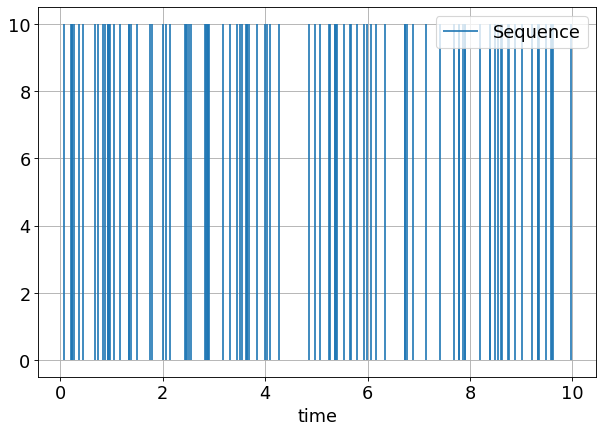

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6), dpi=80)
plt.vlines(x=seq, ymin=0, ymax=10, label = 'Sequence')
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

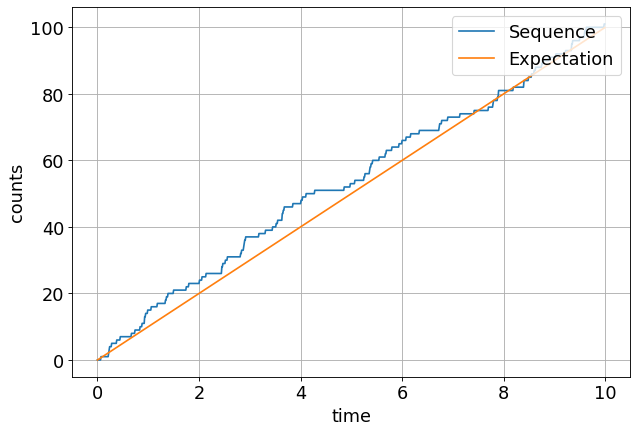

In [ ]:
times = torch.arange(0,10,0.01)
counts = torch.Tensor([torch.sum(seq<=t) for t in times])
expected = lam * times

plt.figure(figsize=(9, 6), dpi=80)
plt.plot(times, counts, label = 'Sequence')
plt.plot(times, expected, label = 'Expectation')
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.ylabel("counts", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Эмпирические распределения однородного пуассоновского процесса

#### Задача: Построить империческую PDF против истинной PDF и эмпиричиескую функцию Выживания против истинной функция Выживания.

In [ ]:
# let's generate sequence
T = 10000
lam = 10

seq = simulate_poisson_inverse(lam, T)

In [ ]:
# let's compute return time
return_time = seq[1:] - seq[:-1]

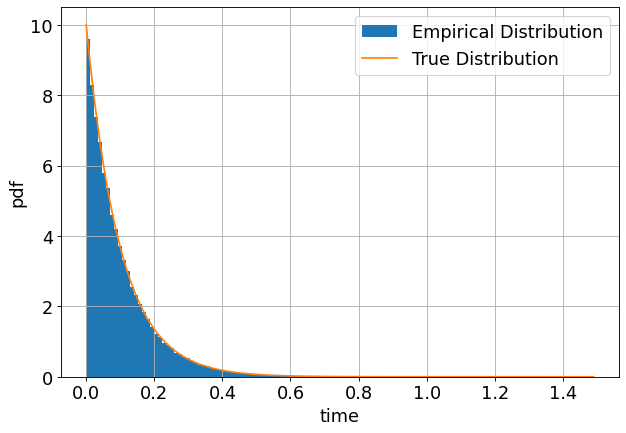

In [ ]:
times = torch.arange(0,1.5,0.01)
pdf = lam*torch.exp(-lam*times)

plt.figure(figsize=(9, 6), dpi=80)
plt.hist(return_time, bins=100, density=True, label="Empirical Distribution")
plt.plot(times, pdf, label="True Distribution")
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.ylabel("pdf", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

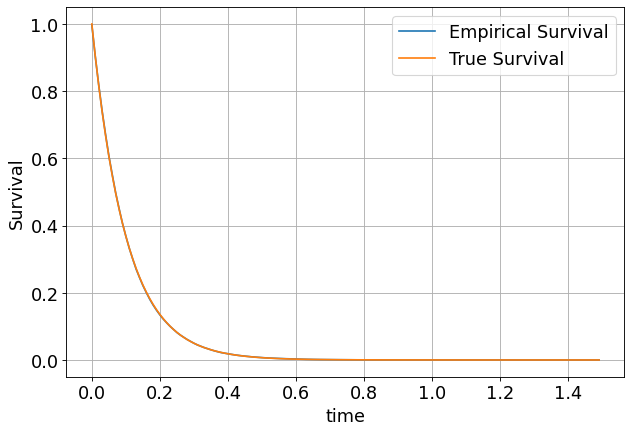

In [ ]:
times = torch.arange(0,1.5,0.01)
survival = torch.Tensor([torch.sum(return_time>t)/len(seq) for t in times])
true_survival = torch.exp(-lam*times)

plt.figure(figsize=(9, 6), dpi=80)
plt.plot(times, survival, label="Empirical Survival")
plt.plot(times, true_survival, label="True Survival")
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.ylabel("Survival", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Генерация неоднородного пуассоновского процесса

Допустим, у нас есть неоднородный процесс Пуассона, и мы хотим сгенерировать последовательность из соответствующего распределения.

#### Вопрос: как мы можем провести эту выборку?



Используя алгоритм разделения (thinning algorithm).

Предположим, что мы хотим сгенерировать последовательность с неоднородным процессом Пуассона с следующей функцией интенсивности $\lambda(t)$.

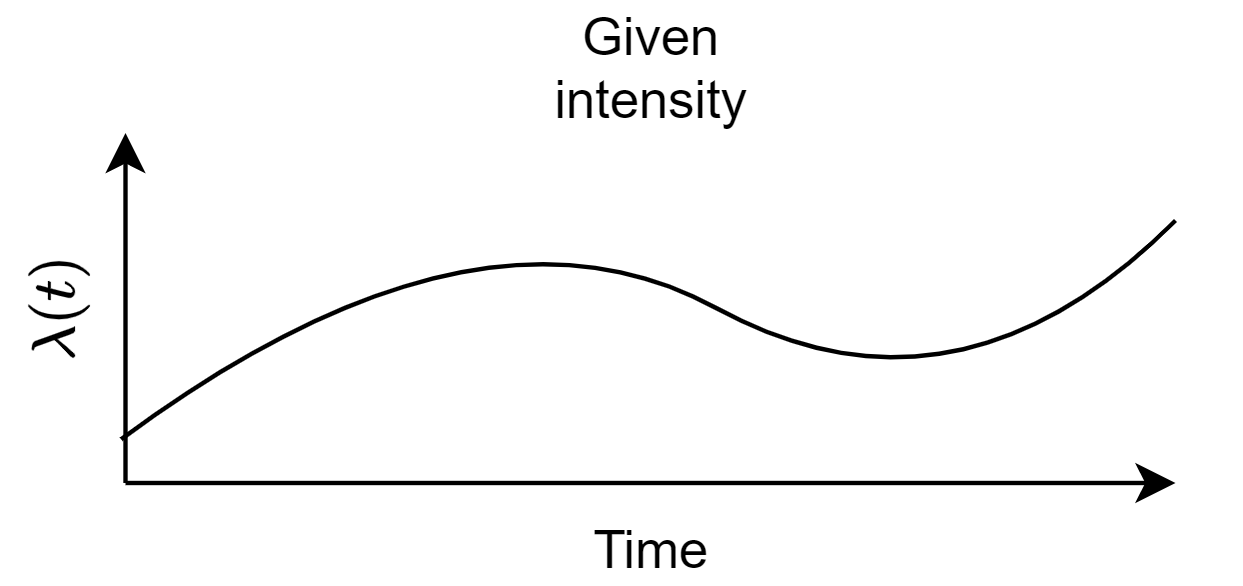

Давайте введем функцию интенсивности $\hat{\lambda}(t) = C$, такую, что $\forall t: \lambda(t) \leq C$.



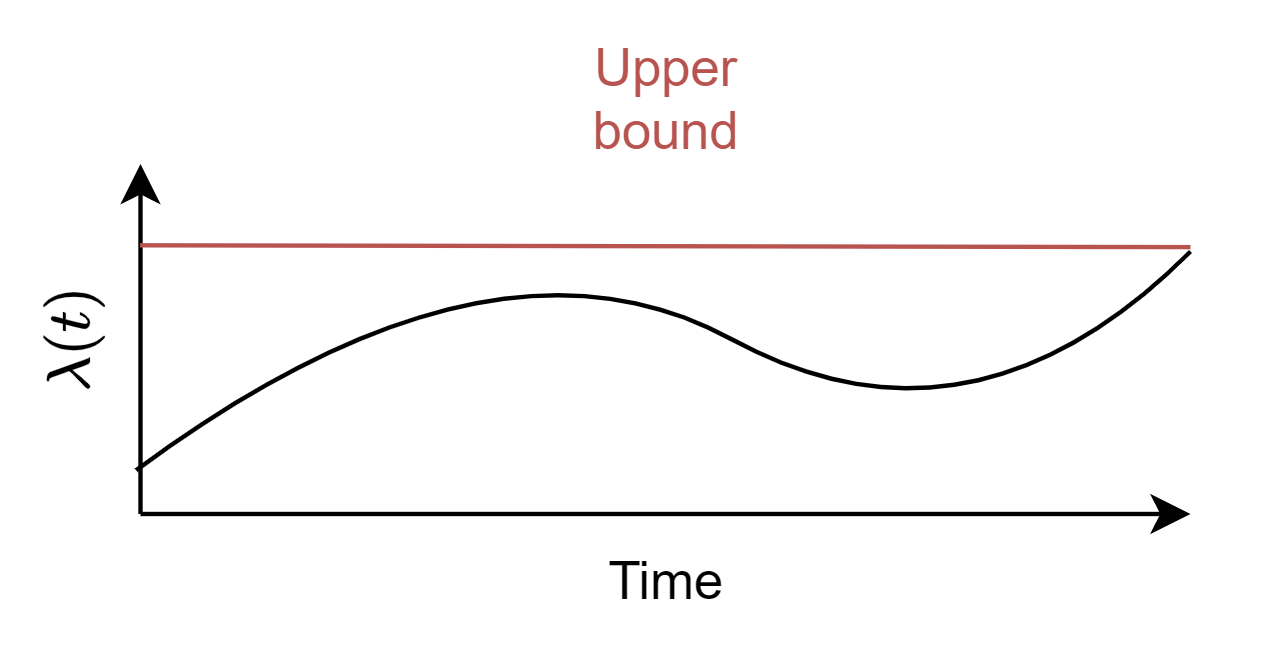

Теперь давайте введем дополнительный точечный процесс с интенсивностью $\lambda_a(t) = \hat{\lambda} - \lambda(t)$. И давайте рассмотрим двух типов однородный пуассоновский процесс. И давайте сгенерируем последовательность.



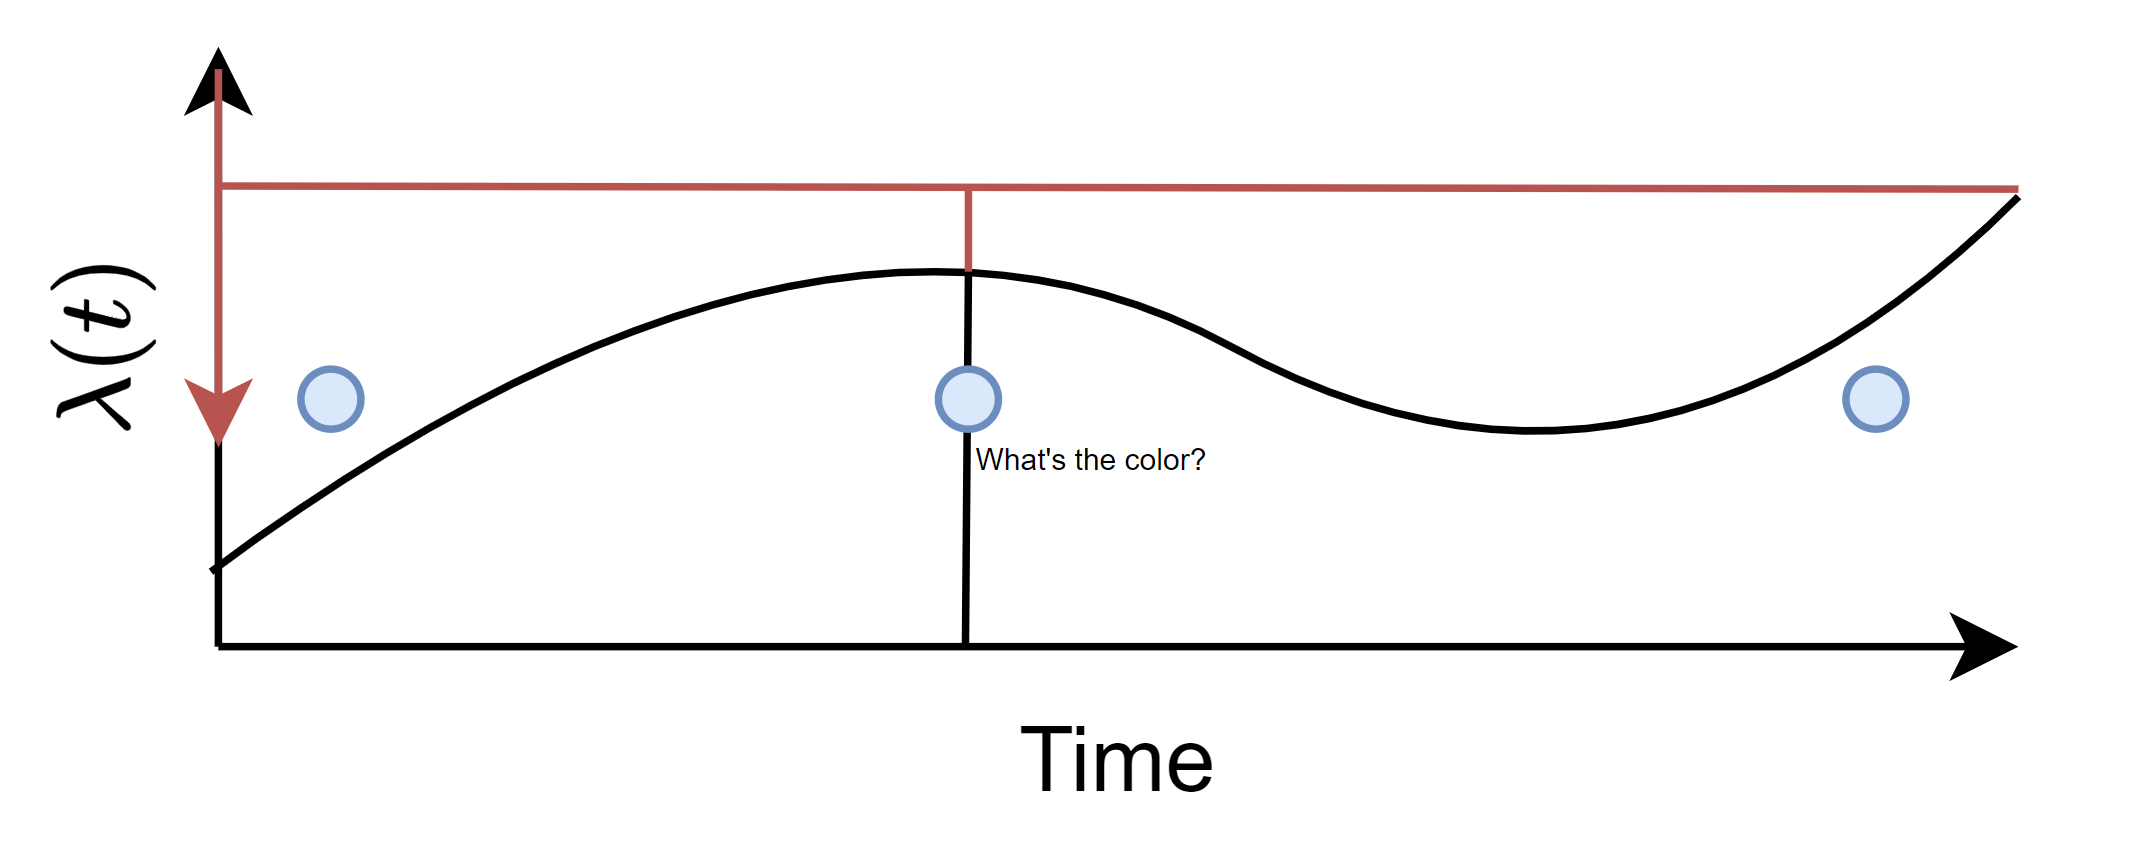

Поскольку эти два подпроцесса с интенсивностью $\lambda(t)$ и $\lambda_a(t)$ независимы, вместе они будут представлять собой однородный пуассоновский процесс с функцией интенсивности, равной их сумме. Вопрос заключается в том, как мы можем определить, было ли событие сгенерировано с использованием $\lambda(t)$ или $\lambda_a(t)$. Интенсивность показывает частоту. Поэтому мы можем определить вероятность того, что данная точка была сгенерирована с использованием $\lambda(t)$ как $\lambda(t)/\hat{\lambda}$.

#### Задача: Используя только ```torch.rand``` сгенерировать последовательность для интенсивности $\lambda(t) = 5 (1+\sin(t))$, $t\in[0,10]$.

In [ ]:
import torch
import torch.nn as nn
torch.random.manual_seed(12)

# true intensity
lambda_true = lambda t: 5 * (1 + torch.sin(t))

# code here

T = 10
lambda_hat = 10

auxiliary_seq = simulate_poisson_inverse(10, T)

probas = lambda_true(auxiliary_seq)/lambda_hat
indices = (probas > torch.rand((len(auxiliary_seq),)))

seq = auxiliary_seq[indices]# output, do not change the name of this variable

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2816385778.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda$", fontsize=16)


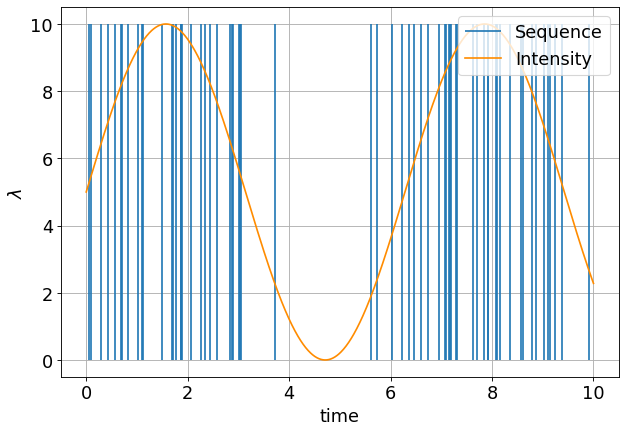

In [ ]:
import matplotlib.pyplot as plt

times = torch.linspace(0,10,1000)
lambdas = lambda_true(times)

plt.figure(figsize=(9, 6), dpi=80)
plt.vlines(x=seq, ymin=0, ymax=10, label = 'Sequence')
plt.plot(times, lambdas, label = 'Intensity', color='darkorange')
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.ylabel("$\lambda$", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Генерация процесса Хоукса

#### Вопрос: Как мы можем сгенерировать последовательность для Процесса Хоукса?

Последовательно, имея функцию интенсивности $\lambda(t|\mathcal{H}_{i-1})$, мы генерируем последовательность, используя алгоритм разделения (thinning algorithm), берем первую точку и добавляем ее в последовательность процесса Хоукса $\mathcal{H}_{i-1} += \{t_i, c_i\}$, затем повторяем процесс.

#### Задача: Допустим, у нас есть процесс Хоукса с экспоненциальным ядром убывания и одним типом события $\lambda^*(t) = 1 + \sum_{i: t_i<t}5\exp(-15(t-t_i))$. Сгенерируйте последовательность с соответствующим законом интенсивности. Реализуйте класс процесса Хоукса.

In [ ]:
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point = False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    # code here

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    # code here

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    # code here

##### Интенсивность

In [ ]:
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point =  False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    if len(seq) > 0:
      delta_t = t - seq
      if not in_point:
        delta_t = delta_t[delta_t > 0]
      else:
        delta_t = delta_t[delta_t >= 0]
      return self.mu + torch.sum(self.a * torch.exp(- self.delta * delta_t))
    else:
      return self.mu

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    # code here, you can use the code from the previous seminar for Nonhomogeneous Poisson

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    # code here

##### Генерация следующей точки

In [ ]:
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point =  False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    if len(seq) > 0:
      delta_t = t - seq
      if not in_point:
        delta_t = delta_t[delta_t > 0]
      else:
        delta_t = delta_t[delta_t >= 0]
      return self.mu + torch.sum(self.a * torch.exp(- self.delta * delta_t))
    else:
      return self.mu

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    if len(seq) > 0:
        t = seq[-1].item()
        lambda_bar = self.intensity(seq[-1], seq, in_point=True).item()  # верхняя граница в начале интервала
    else:
        t = 0.0
        lambda_bar = float(self.mu)

    while True:
        # 1) предложение
        u = torch.rand(1).item()
        w = -math.log1p(-u) / lambda_bar   # Exp(lambda_bar)
        t = t + w                           # 2) двигаем время вперёд

        # 3) реальная интенсивность в новой точке
        lam_t = self.intensity(t, seq, in_point=False)

        # 4) тест принятия
        if torch.rand(1).item() <= lam_t / lambda_bar:
            return torch.cat([seq, torch.tensor([t])])
        else:
            # отказ: новая верхняя граница — текущая интенсивность (монотонная убывающая)
            lambda_bar = lam_t

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    # code here

##### Генерация последовательности

In [ ]:
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point =  False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    if len(seq) > 0:
      delta_t = t - seq
      if not in_point:
        delta_t = delta_t[delta_t > 0]
      else:
        delta_t = delta_t[delta_t >= 0]
      return self.mu + torch.sum(self.a * torch.exp(- self.delta * delta_t))
    else:
      return self.mu

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    if len(seq) > 0:
        t = seq[-1].item()
        lambda_bar = self.intensity(seq[-1], seq, in_point=True).item()  # верхняя граница в начале интервала
    else:
        t = 0.0
        lambda_bar = float(self.mu)

    while True:
        # 1) предложение
        u = torch.rand(1).item()
        w = -math.log1p(-u) / lambda_bar   # Exp(lambda_bar)
        t = t + w                           # 2) двигаем время вперёд

        # 3) реальная интенсивность в новой точке
        lam_t = self.intensity(t, seq, in_point=False)

        # 4) тест принятия
        if torch.rand(1).item() <= lam_t / lambda_bar:
            return torch.cat([seq, torch.tensor([t])])
        else:
            # отказ: новая верхняя граница — текущая интенсивность (монотонная убывающая)
            lambda_bar = lam_t

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    seq = torch.Tensor([])

    seq = self.generate_next_point(seq)

    while True:
      if max_time is not None:
        if seq[-1] > max_time:
          break
      if max_jumps is not None:
        if len(seq) > max_jumps:
          break

      seq = self.generate_next_point(seq)

    seq = seq[:-1]
    return seq


In [ ]:
model = Hawkes(1,5,15)
seq = model.generate_sequence(max_jumps = 1000)

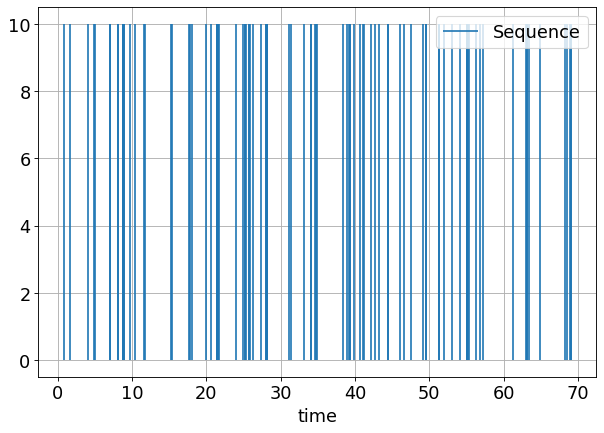

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6), dpi=80)
plt.vlines(x=seq[:100], ymin=0, ymax=10, label = 'Sequence')
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

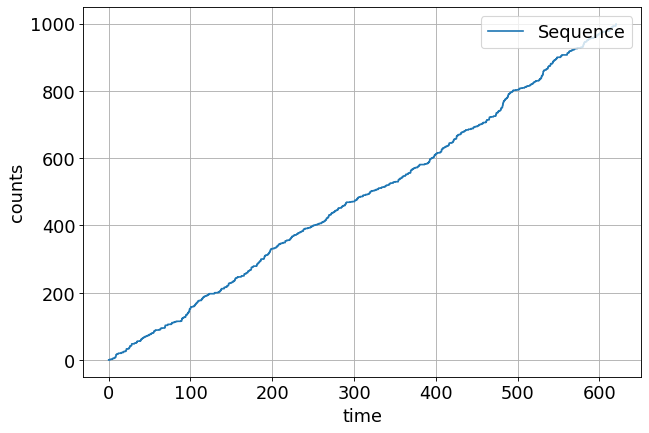

In [ ]:
times = torch.arange(0,seq[-1],0.01)
counts = torch.Tensor([torch.sum(seq<=t) for t in times])

plt.figure(figsize=(9, 6), dpi=80)
plt.plot(times, counts, label = 'Sequence')
plt.legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
plt.xlabel("time", fontsize=16)
plt.ylabel("counts", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Предсказание с помощью процесса Хоукса

#### Задача: Реализовать предсказание ожидаемого времени возврата для процесса Хоукса с экспоненциальным ядром убывания.

In [ ]:
from scipy.integrate import quad
import numpy as np
import torch

class Hawkes:
  def __init__(self, mu, a, delta):
    self.mu = mu
    self.a = a
    self.delta = delta

  def intensity(self, t, seq, in_point =  False):
    """
    Returns intensity function in the momemt of time t given the sequence
    If in_point is true change the inequality from t_i < t to t_i <= t, this will be useful for sequence generation
    """
    # code here
    if len(seq) > 0:
      delta_t = t - seq
      if not in_point:
        delta_t = delta_t[delta_t > 0]
      else:
        delta_t = delta_t[delta_t >= 0]
      return self.mu + torch.sum(self.a * torch.exp(- self.delta * delta_t))
    else:
      return self.mu

  def generate_next_point(self, seq):
    """
    Generates the next event in the sequence
    """
    if len(seq) > 0:
        t = seq[-1].item()
        lambda_bar = self.intensity(seq[-1], seq, in_point=True).item()  # верхняя граница в начале интервала
    else:
        t = 0.0
        lambda_bar = float(self.mu)

    while True:
        # 1) предложение
        u = torch.rand(1).item()
        w = -math.log1p(-u) / lambda_bar   # Exp(lambda_bar)
        t = t + w                           # 2) двигаем время вперёд

        # 3) реальная интенсивность в новой точке
        lam_t = self.intensity(t, seq, in_point=False)

        # 4) тест принятия
        if torch.rand(1).item() <= lam_t / lambda_bar:
            return torch.cat([seq, torch.tensor([t])])
        else:
            # отказ: новая верхняя граница — текущая интенсивность (монотонная убывающая)
            lambda_bar = lam_t

  def generate_sequence(self, max_time = None, max_jumps = None):
    """
    Generates one Hawkes Process sequence, limits the sequence with either max_jumps or max_time
    """
    if (max_time is None) and (max_jumps is None):
      raise Exception("Either max_time or max_jumps have to be provided")

    # code here
    seq = torch.Tensor([])

    seq = self.generate_next_point(seq)

    while True:
      if max_time is not None:
        if seq[-1] > max_time:
          break
      if max_jumps is not None:
        if len(seq) > max_jumps:
          break

      seq = self.generate_next_point(seq)

    seq = seq[:-1]
    return seq

  def return_time_prediction(self, seq):
    alpha = self.mu/self.delta
    dts = seq[-1] - seq
    beta = - float(self.a/self.delta * torch.sum(torch.exp(-self.delta*(dts))))

    def func(z, delta = self.delta, alpha = alpha, beta = beta):
      return z**(alpha - 1) * np.exp(beta * (1- z))/delta

    return quad(func, 0, 1)[0]

#### Задача: Предсказать времена возврата для нашей сгенерированной последовательности и вычислить среднюю квадратичную ошибку (MSE).

In [ ]:
model = Hawkes(1,5,15)
return_times_predicted = torch.Tensor([model.return_time_prediction(seq[:i+1]) for i in range(len(seq) - 1)])

In [ ]:
return_times = seq[1:] - seq[:-1]
MSE = torch.mean((return_times - return_times_predicted)**2)
print(f"{MSE = }")

MSE = tensor(0.7337)


#### Задача: Обучить однородный пуассоновский процесс и вычислить среднюю абсолютную ошибку (MAE).

In [ ]:
lambda_pred = len(seq)/seq[-1]
print('Poisson lambda =', lambda_pred)

expected_return_time = 1/lambda_pred
MSE = torch.mean((return_times - expected_return_time) ** 2)
print(f"{MSE = }")

Poisson lambda = tensor(1.6122)
MSE = tensor(0.7346)


### Обучение модели процесса Хоукса

#### Генерация данных

Давайте сгенерируем данные с только одним типом события и фиксированной длиной последовательности.

In [ ]:
import tqdm

seed = 42
N = 10000
val_test_N = 100

mu = 1.0
a = 0.35
delta = 0.7

torch.manual_seed(seed)

model = Hawkes(mu, a, delta)
train_dataset = torch.vstack([model.generate_sequence(max_jumps = 128) for i in tqdm.tqdm(range(N))])
test_dataset = torch.vstack([model.generate_sequence(max_jumps = 128) for i in tqdm.tqdm(range(val_test_N))])

100%|██████████| 100/100 [00:03<00:00, 31.90it/s]


In [ ]:
train_dataset[0]

tensor([ 2.1394,  2.8859,  3.0763,  4.6140,  6.2814,  7.5966,  8.4583,  9.7628,
         9.9548, 10.1212, 10.2858, 10.3329, 10.4992, 10.7784, 11.8362, 12.8066,
        13.0149, 13.8320, 14.3289, 15.8385, 16.7405, 17.5488, 17.5516, 17.6102,
        18.0368, 18.4833, 19.4169, 19.7838, 20.2720, 20.7567, 21.8787, 21.9977,
        26.1163, 26.1191, 26.2204, 26.9321, 27.6584, 28.4932, 29.3139, 29.4681,
        29.9095, 30.7361, 32.3172, 32.5489, 32.6735, 32.9320, 33.2367, 33.2690,
        33.2923, 36.8798, 37.0038, 37.4765, 37.6489, 37.9672, 38.2396, 38.3099,
        38.4573, 39.3286, 40.4490, 40.4893, 40.6849, 40.7207, 41.0889, 41.5220,
        42.3000, 42.5323, 44.6911, 45.2795, 45.6078, 47.1780, 48.0472, 48.6793,
        50.3848, 50.9054, 51.6070, 51.7808, 52.2367, 52.3698, 53.0045, 53.1127,
        53.1668, 53.9486, 54.3500, 54.7229, 55.3130, 55.8195, 56.0225, 56.2399,
        57.2015, 57.5292, 57.9554, 57.9758, 58.9430, 59.2392, 59.3328, 59.4925,
        60.1122, 60.1363, 60.6594, 61.13

Для нахождения параметров процесса Хокса нам нужно минимизировать следующую отрицательную логарифмическую функцию правдоподобия:
$$
Loss = - \sum_{i=1}^{N}\left(\sum_{j=1}^{L}\log\lambda(t_{i,j}) -\int_{0}^{t_{i,L}}\lambda(u)du\right)
$$

Чаще всего эта задача решается с использованием методов максимизации ожидания (expectation maximization) или методов стохастического градиентного спуска (SGD).

Работы:
- Xu, Hongteng & Chen, Xu & Carin, Lawrence. (2018). Superposition-Assisted Stochastic Optimization for Hawkes Processes.
- Joseph, Sobin & Kashyap, Lekhapriya & Jain, Shashi. (2020). Shallow Neural Hawkes: Non-parametric kernel estimation for Hawkes processes.
- Zhang, Rui & Walder, Christian & Rizoiu, Marian-Andrei & Xie, Lexing. (2018). Efficient Non-parametric Bayesian Hawkes Processes.

Чтобы упростить задачу, давайте решим ее с использованием постоянной базы, экспоненциальных ядер и оптимизации методом стохастического градиентного спуска (SGD) для этой параметрической формы. Мы будем использовать класс ```torch.nn.Module``` для использования всех преимуществ моделей torch.

#### Задача: Перепишите функцию потерь в такой форме, чтобы ее можно было использовать при вычислениях потерь для батчей.

*Примечание: Предположите, что все последовательности имеют одинаковую длину.*

Допустим, у нас есть последовательность событий $\mathbf{s} = \{t_i\}_{i=1}^L$. Введем матрицу:
$$
\mathbf{S}_{i,j} = t_i - t_j
$$

Для данной последовательности $\mathbf{s}$ давайте найдем $\sum_{i} \log \lambda(t_i)$. Мы знаем, что $\lambda^*(t) = \mu + \sum_{i: t_i < t} a \exp(-\delta (t -t_j))$.

Пусть
$$
\mathbf{V} = \begin{pmatrix}
                    0 & 0 & 0 &\cdots & 0 \\
                    1 & 0 & 0 &\cdots & 0 \\
                    1 & 1 & 0 &\cdots & 0 \\
                    \vdots & \vdots & \vdots & \ddots & \vdots \\
                    1 & 1 & 1 & \cdots & 0\end{pmatrix} \in \mathbb{R}^{L \times L}
$$

Затем можно найти интенсивности следующим образом:
$$
\lambda(t_i) = \mu + \sum_{j} \left[\exp\left(-\delta \mathbf{S}\right) \odot (aV)\right]_{ij}
$$

Здесь $\exp$ - это поэлементное экспоненциирование, а $\odot$ - поэлементное умножение.

Теперь давайте найдем интеграл.

$$
\lambda(t) = \mu + \sum_{i: t_i < t} a\exp(-\delta(t-t_i)) = \mu + \sum_{i}a\exp(-\delta(t-t_i))\theta(t-t_i)
$$

Здесь $\theta$ - это функция Хевисайда (step function), поэтому $\theta(x) = \begin{cases}1, ~ \text{если}~x>0\\0, ~\text{иначе}\end{cases}$.
$$
\int_{0}^{t_L}\lambda(t)dt = \mu t_L - \sum_{i}\frac{a}{\delta}\exp(-\delta(t - t_i))\big{|}_{t_i}^{t_L} = \mu t_L + \sum_{i}\frac{a}{\delta}(1 - \exp(-\delta(t_L - t_i)))
$$

Затем мы должны подставить эти формулы в отрицательное логарифмическое правдоподобие.

#### Задача: Допишите недостающие части.

In [ ]:
L=5

torch.tril(torch.ones((L,L)), diagonal=-1)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])

In [ ]:
class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

##### Lambdas

In [ ]:
class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

##### Integral

In [ ]:
import torch

class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here
    base = self.mu * batch[:, -1]
    last = batch[:,-1].unsqueeze(1).repeat(1,self.L)
    exps = (self.a - self.a * torch.exp(-self.delta * (last - batch)))/self.delta

    integral_loss = torch.sum(base) + torch.sum(exps)
    return integral_loss

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

#### Обучение

Мы будем обучать модель с использованием стохастического градиентного спуска (SGD), поэтому давайте реализуем функцию для обучения одной эпохи (train epoch function).

In [ ]:
import numpy as np

def train(model, ref_model, train_loader, optimizer, epoch):
    model.train()
    ll = []
    mse_lambdas = []
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        lambdas = model.lambdas(batch)
        ref_lambdas = ref_model.lambdas(batch)
        mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())
        negative_ll = model(batch)
        negative_ll.backward()
        optimizer.step()
        ll.append(negative_ll.item())
    return np.mean(ll), np.mean(mse_lambdas)

def test_lambda_mse(model, ref_model, test_loader):
    with torch.no_grad():
      model.eval()
      mse_lambdas = []
      for batch_idx, batch in enumerate(test_loader):
          lambdas = model.lambdas(batch)
          ref_lambdas = ref_model.lambdas(batch)
          mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())

      return np.mean(mse_lambdas)

Теперь давайте запустим алгоритм обучения. Мы построим графики для $\mu$, $a$ и $\delta$, а также сравним предсказание интенсивности с эталонной моделью.

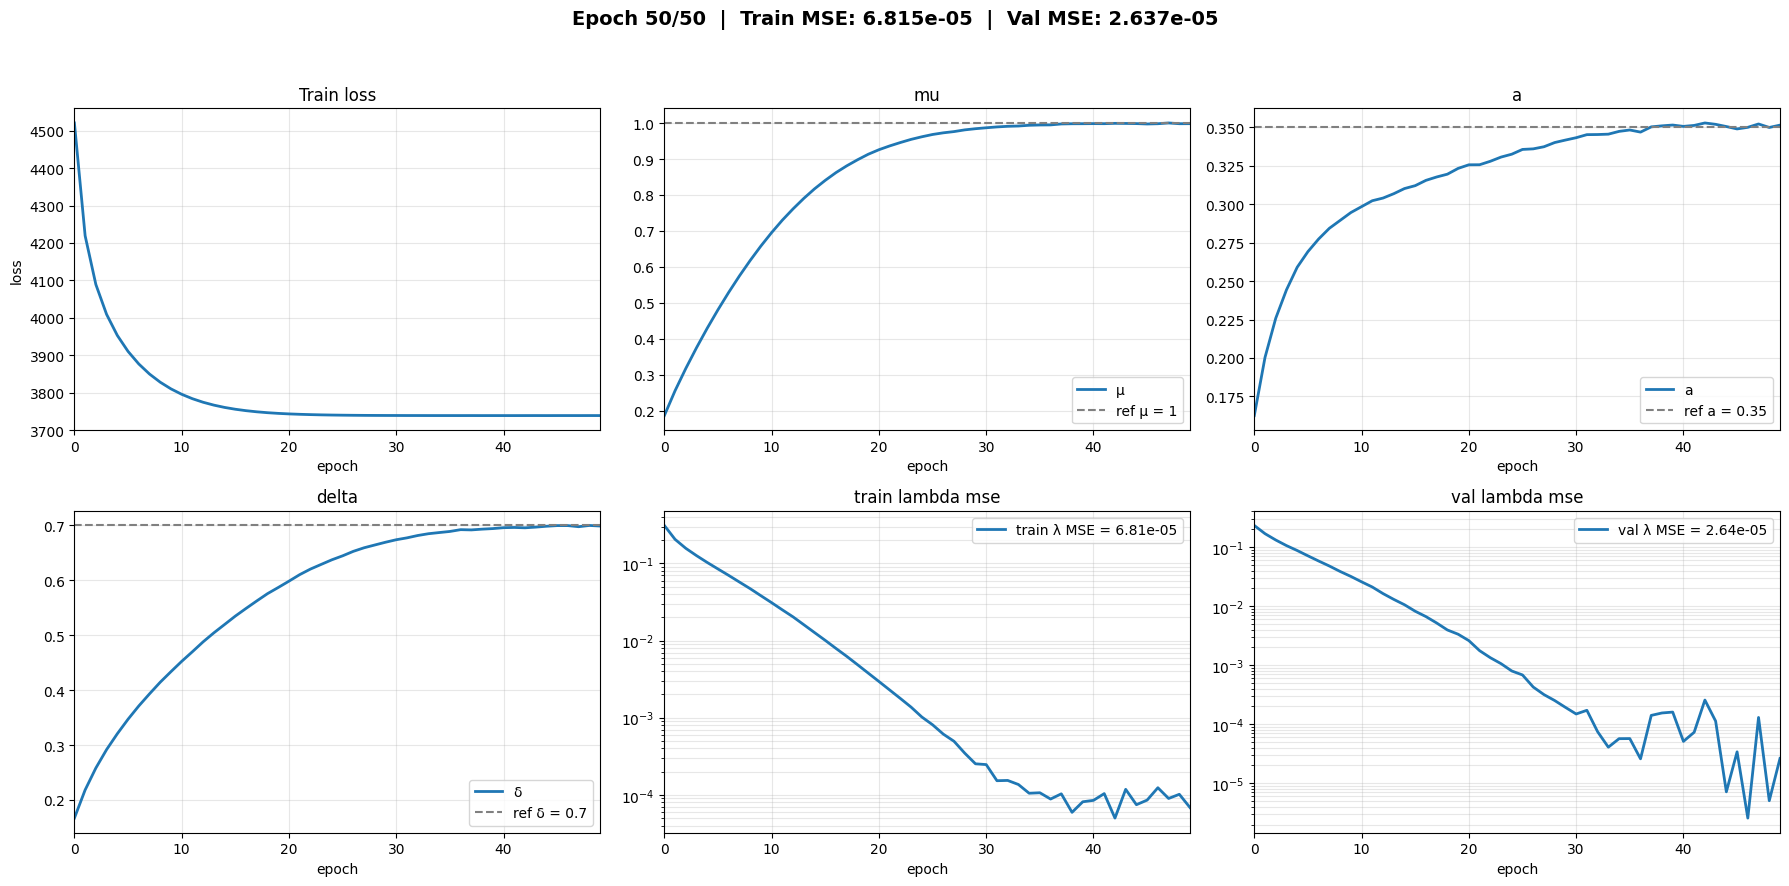

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

max_epochs = 50  # фиксируем горизонт оси X

model = HawkesModel(128)
ref_model = HawkesModel(128, 1.0, 0.35, 0.7)
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses, mu, a, delta = [], [], [], []
mse_lambdas, test_mse_lambdas = [], []

# реф. значения
ref_mu    = float(ref_model.mu.detach().cpu().numpy()[0])
ref_a     = float(ref_model.a.detach().cpu().numpy()[0])
ref_delta = float(ref_model.delta.detach().cpu().numpy()[0])

for epoch in range(max_epochs):
    clear_output(wait=True)

    train_loss, train_mse = train(model, ref_model, train_dataloader, optimizer, epoch)
    val_mse = test_lambda_mse(model, ref_model, test_dataloader)

    losses.append(float(train_loss))
    mse_lambdas.append(float(train_mse))
    test_mse_lambdas.append(float(val_mse))
    mu.append(float(model.mu.detach().cpu().numpy()[0]))
    a.append(float(model.a.detach().cpu().numpy()[0]))
    delta.append(float(model.delta.detach().cpu().numpy()[0]))

    # ---- дашборд ----
    fig, axes = plt.subplots(2, 3, figsize=(18, 9))
    fig.suptitle(
        f"Epoch {epoch+1}/{max_epochs}  |  Train MSE: {train_mse:.3e}  |  Val MSE: {val_mse:.3e}",
        fontsize=14, fontweight="bold"
    )

    # 1) Train loss
    axes[0,0].plot(losses, lw=2)
    axes[0,0].set_title("Train loss")
    axes[0,0].set_xlabel("epoch")
    axes[0,0].set_ylabel("loss")
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(0, max_epochs-1)

    # 2) mu
    axes[0,1].plot(mu, lw=2, label="μ")
    axes[0,1].axhline(ref_mu, ls="--", color="gray", lw=1.5, label=f"ref μ = {ref_mu:.3g}")
    axes[0,1].set_title("mu")
    axes[0,1].set_xlabel("epoch")
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend(loc="best")
    axes[0,1].set_xlim(0, max_epochs-1)

    # 3) a
    axes[0,2].plot(a, lw=2, label="a")
    axes[0,2].axhline(ref_a, ls="--", color="gray", lw=1.5, label=f"ref a = {ref_a:.3g}")
    axes[0,2].set_title("a")
    axes[0,2].set_xlabel("epoch")
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].legend(loc="best")
    axes[0,2].set_xlim(0, max_epochs-1)

    # 4) delta
    axes[1,0].plot(delta, lw=2, label="δ")
    axes[1,0].axhline(ref_delta, ls="--", color="gray", lw=1.5, label=f"ref δ = {ref_delta:.3g}")
    axes[1,0].set_title("delta")
    axes[1,0].set_xlabel("epoch")
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend(loc="best")
    axes[1,0].set_xlim(0, max_epochs-1)

    # 5) Train λ MSE (log-scale)
    axes[1,1].plot(mse_lambdas, lw=2, label=f"train λ MSE = {train_mse:.2e}")
    axes[1,1].set_title("train lambda mse")
    axes[1,1].set_xlabel("epoch")
    axes[1,1].set_yscale("log")
    axes[1,1].grid(True, which="both", alpha=0.3)
    axes[1,1].legend(loc="upper right")
    axes[1,1].set_xlim(0, max_epochs-1)

    # 6) Val λ MSE (log-scale)
    axes[1,2].plot(test_mse_lambdas, lw=2, label=f"val λ MSE = {val_mse:.2e}")
    axes[1,2].set_title("val lambda mse")
    axes[1,2].set_xlabel("epoch")
    axes[1,2].set_yscale("log")
    axes[1,2].grid(True, which="both", alpha=0.3)
    axes[1,2].legend(loc="upper right")
    axes[1,2].set_xlim(0, max_epochs-1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
print(model)

lambda = 0.998 + sum 0.351 * exp( - 0.699 (t - t_i))


Как видите, мы получили результаты, которые схожи с моделью генерации.

### Обучение Трансформера

#### Multi-head attention

В отличие от single-head attention, который использует один набор матриц для запросов, ключей и значений,  
multi-head версия позволяет модели параллельно фокусироваться на разных аспектах последовательности.  
Кроме того, мы будем использовать **замаскированное внимание**, чтобы модель не могла "заглядывать в будущее" —  
это необходимо для авторегрессионных задач.

Давайте реализуем:
```python
class MultiHeadAttention(nn.Module):
    def __init__(self, M, num_heads):
        super().__init__()
        self.M = M
        self.H = num_heads
        self.inner_dim = M * num_heads  # внутренняя размерность увеличивается пропорционально числу голов

        self.W_Q = nn.Linear(M, self.inner_dim)
        self.W_K = nn.Linear(M, self.inner_dim)
        self.W_V = nn.Linear(M, self.inner_dim)
        self.W_O = nn.Linear(self.inner_dim, M)

```
Пояснение параметров:

- M — размерность встраивания (embedding dimension);
- num_heads — число голов внимания;
- inner_dim — общая размерность после объединения всех голов.

Соответствующие веса:
```python
    self.W_Q = nn.Linear(M, self.inner_dim, bias=bias)
    self.W_K = nn.Linear(M, self.inner_dim, bias=bias)
    self.W_V = nn.Linear(M, self.inner_dim, bias=bias)
    self.W_O = nn.Linear(self.inner_dim, M, bias=bias)
```

Теперь реализуем forward слой:
```python
  def forward(self, X: Tensor, key_padding_mask: Tensor = None) -> Tensor:
    """
    X: (B, L, M)
    key_padding_mask: (B, L), где True = PAD
    """
    B, L, _ = X.shape

    # 1) Проекции
    Q = self.W_Q(X)  # (B, L, M*H)
    K = self.W_K(X)
    V = self.W_V(X)

    # 2) Разделение на головы
    Q = Q.view(B, L, self.H, self.M).transpose(1, 2)  # (B, H, L, M)
    K = K.view(B, L, self.H, self.M).transpose(1, 2)
    V = V.view(B, L, self.H, self.M).transpose(1, 2)

    # 3) Оценка внимания
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.M)  # (B, H, L, L)

    # Маски
    if self.causal:
        causal_mask = self._make_causal_mask(L, X.device)
        scores = scores.masked_fill(causal_mask, float('-inf'))

    if key_padding_mask is not None:
        pad = key_padding_mask.unsqueeze(1).unsqueeze(1)
        scores = scores.masked_fill(pad, float('-inf'))

    attn = torch.softmax(scores, dim=-1)
    attn = self.attn_drop(attn)

    # 4) Применение внимания
    context = torch.matmul(attn, V)  # (B, H, L, M)

    # 5) Объединение голов
    context = context.transpose(1, 2).contiguous().view(B, L, self.inner_dim)  # (B, L, M*H)
    out = self.W_O(context)  # (B, L, M)
    return out

```
Прежде чем применять softmax и вычислять оценки, мы должны замаскировать будущее. Мы будем использовать -inf, который всегда будет возвращать 0 для softmax.

Каждая "голова" вычисляет собственное внимание,
а результаты объединяются и проходят через выходную линейную проекцию.

Multi-head внимание позволяет модели улавливать различные типы зависимостей
между событиями и улучшает способность к обобщению контекста.

In [ ]:
import math
import torch
import torch.nn as nn
from torch import Tensor

class MultiHeadAttention(nn.Module):
    """
    Мультихед-внимание без требования делимости M на num_heads.
    Общая внутренняя размерность масштабируется как M * num_heads.
    """
    def __init__(self, M: int, num_heads: int,
                 dropout: float = 0.0, causal: bool = True, bias: bool = False):
        super().__init__()

        self.M = M
        self.H = num_heads
        self.d_k = M                # размерность каждой головы (на вход)
        self.d_v = M
        self.inner_dim = M * num_heads
        self.causal = causal

        # Проекции Q, K, V и выходная проекция
        self.W_Q = nn.Linear(M, self.inner_dim, bias=bias)
        self.W_K = nn.Linear(M, self.inner_dim, bias=bias)
        self.W_V = nn.Linear(M, self.inner_dim, bias=bias)
        self.W_O = nn.Linear(self.inner_dim, M, bias=bias)

        self.attn_drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self._reset_parameters()

    def _reset_parameters(self):
        for m in [self.W_Q, self.W_K, self.W_V, self.W_O]:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def _make_causal_mask(self, L: int, device: torch.device):
        # Верхний треугольник (без диагонали) = True → запрещено смотреть вперёд
        mask = torch.triu(torch.ones(L, L, device=device, dtype=torch.bool), diagonal=1)
        return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, L, L)

    def forward(self, X: Tensor, key_padding_mask: Tensor = None) -> Tensor:
        """
        X: (B, L, M)
        key_padding_mask: (B, L), где True = PAD
        """
        B, L, _ = X.shape

        # 1) Проекции
        Q = self.W_Q(X)  # (B, L, M*H)
        K = self.W_K(X)
        V = self.W_V(X)

        # 2) Разделение на головы
        Q = Q.view(B, L, self.H, self.M).transpose(1, 2)  # (B, H, L, M)
        K = K.view(B, L, self.H, self.M).transpose(1, 2)
        V = V.view(B, L, self.H, self.M).transpose(1, 2)

        # 3) Оценка внимания
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.M)  # (B, H, L, L)

        # Маски
        if self.causal:
            causal_mask = self._make_causal_mask(L, X.device)
            scores = scores.masked_fill(causal_mask, float('-inf'))

        if key_padding_mask is not None:
            pad = key_padding_mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(pad, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)

        # 4) Применение внимания
        context = torch.matmul(attn, V)  # (B, H, L, M)

        # 5) Объединение голов
        context = context.transpose(1, 2).contiguous().view(B, L, self.inner_dim)  # (B, L, M*H)
        out = self.W_O(context)  # (B, L, M)
        return out


#### Feed forward слой

Теперь давайте реализуем слой прямой связи, который следует использовать после внимания нескольких голов.

Это просто дополнительный слой, который состоит из двух полносвязных слоев и ReLU.

In [ ]:
class FeedForwardLayer(nn.Module):
  def __init__(self, M, M_H):
    super().__init__()
    self.layer_1 = nn.Linear(M, M_H)
    self.layer_2 = nn.Linear(M_H, M)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_2(self.relu(self.layer_1(x)))

#### Модель Трансформера

##### Инициализация

Теперь давайте объединим все части в модель трансформера. Отдельно реализуем класс одного слоя с последовательным применением нормализаций, аттеншн слоя, feed-forward слоя и Dropout-а.

Отдельно рассмотрим особенности трансформера для последовательностей событий.

##### Лямбда-вычисление

Для вычисления интенсивности событий нам необходимо реализовать два связанных метода:  
`get_lambdas_batch(self, hiddens, times)` и `get_lambdas(self, t, hidden, t_j, simulated=False)`.

- **`get_lambdas_batch`** — это вспомогательная функция, которая подготавливает данные батча: разделяет времена на «прошлые» и «будущие», выбирает соответствующие скрытые состояния и вызывает общий метод `get_lambdas`.  
- **`get_lambdas`** — основной метод, вычисляющий значения интенсивности λ(t) для заданных времён, скрытых состояний и предыдущих событий. Именно он реализует формулу из статьи *Transformer Hawkes Process*.

**Подготовка данных**

Так как модель должна предсказывать интенсивность следующего события с учётом всей предыдущей истории,  
мы разбиваем времена на два набора: `past_times` (все события до текущего) и `future_times` (следующее событие после каждого).  
Интенсивность λ(tᵢ₊₁) оценивается на основе скрытого состояния в момент tᵢ.

```python
    def get_lambdas_batch(self, hiddens: Tensor, times: Tensor) -> Tensor:
        future_times = times[:, 1:]            # (B, L-1)
        past_times   = times[:, :-1]           # (B, L-1)
        deltas       = future_times - past_times  # (B, L-1) = t_{j+1}-t_j
        past_hiddens = hiddens[:, :-1, :]      # (B, L-1, M)
        lambdas = self.get_lambdas(future_times, past_hiddens, past_times, deltas)
        return lambdas
```

Метод `get_lambdas` реализует формулу из статьи *Transformer Hawkes Process*  
и возвращает значения интенсивности $\lambda(t)$ для всех заданных времён.

Интенсивность зависит от трёх факторов:

1. **Исторический вклад** — $w^\top h_j$,  
   который отражает влияние скрытого состояния предыдущих событий.

2. **Нормализованное время** — $\frac{t - t_j}{t_{j+1} - t_j}$,  
   характеризующее положение текущего момента $t$ внутри интервала между событиями.

3. **Параметры модели** — $\alpha$ и $b$,  
   где $\alpha$ отвечает за вес временного компонента, а $b$ — за базовый уровень интенсивности.

В совокупности это выражение моделирует динамику изменения интенсивности между последовательными событиями.







```python
    def get_lambdas(self, t: Tensor, hidden: Tensor, t_j: Tensor, delta: Tensor, simulated: bool = False) -> Tensor:
        """
        t:       (B, L-1)        или (B, L-1, N)
        hidden:  (B, L-1, M)     — h_j
        t_j:     (B, L-1)
        delta:   (B, L-1)        — (t_{j+1}-t_j), нормировка времени
        """
        # исторический вклад
        hist = torch.matmul(hidden, self.w)                 # (B, L-1)
        if simulated:
            # выравниваем размерности для (B, L-1, N)
            t_j   = t_j.unsqueeze(-1)
            delta = delta.unsqueeze(-1)
            hist  = hist.unsqueeze(-1)

        # линейная интерполяция по времени в интервале [t_j, t_{j+1})
        lin_time = (t - t_j) / (delta + 1e-8)
        tmp = self.alpha * lin_time + hist + self.b
        return self.act(tmp)                                # ReLU/Softplus → λ(t) ≥ 0
```

##### Вычисление интеграла


Чтобы оценить интеграл интенсивности на интервале между событиями, используем несмещённую (unbiased) Монте-Карло аппроксимацию.

На каждом интервале вычисляем вклад  
$$\int_{t_j}^{t_{j+1}} \lambda(t)\,dt.$$

1. Для каждой пары соседних времён определяем длину интервала  
   $\Delta_j = t_{j+1} - t_j$.

2. Сэмплируем $N$ случайных точек внутри интервала:  
   $u_{j,n} \sim \mathrm{Unif}(0,1)$,  
   $t_{j,n} = t_j + u_{j,n} \Delta_j$.

3. Вычисляем интенсивность для каждой точки, условно на историю до $t_j$:  
   $\lambda_{j,n} = \lambda(t_{j,n} \mid \mathcal{H}_{t_j}, h_j)$.

4. Оцениваем интеграл на каждом интервале:  
   $$\widehat{I}_j = \Delta_j \cdot \frac{1}{N} \sum_{n=1}^N \lambda_{j,n}.$$

5. Суммируем по всем интервалам:  
   $$\widehat{\Lambda}_{MC} = \sum_j \Delta_j \cdot \frac{1}{N} \sum_{n=1}^N \lambda(t_j + u_{j,n} \Delta_j \mid \mathcal{H}_{t_j}, h_j).$$

Эта оценка является несмещённой:  
$\mathbb{E}[\widehat{\Lambda}_{MC}] = \int \lambda(t)\,dt$,  
что критически важно для корректной работы градиентного спуска.

На практике:
- Все операции векторизуются для батчей данных.  
- Количество выборок $N$ обычно находится в диапазоне $8$–$64$.  

В результате получаем:

```python
    def get_integrals(self, hiddens: Tensor, times: Tensor, N: int) -> Tensor:
        future_times = times[:, 1:]                      # (B, L-1)
        past_times   = times[:, :-1]                     # (B, L-1)
        deltas       = future_times - past_times         # (B, L-1)
        past_hiddens = hiddens[:, :-1, :]                # (B, L-1, M)

        B, L = deltas.shape
        # u ~ Unif(0,1), t = t_j + u * (t_{j+1}-t_j)
        u = torch.rand(B, L, N, device=times.device)
        sim_times = past_times.unsqueeze(-1) + u * deltas.unsqueeze(-1)                 # (B, L-1, N)

        sim_lambdas = self.get_lambdas(sim_times, past_hiddens, past_times, deltas, simulated=True)  # (B, L-1, N)
        # MC интеграл по каждому интервалу: Δ * E_u[λ(t)]
        interval_integrals = deltas * sim_lambdas.mean(dim=-1)                          # (B, L-1)
        total_integral = interval_integrals.sum(dim=1)                                  # (B,)
        return total_integral

```



##### Код

In [ ]:
import math
import torch
import torch.nn as nn
from torch import Tensor


class TransformerBlock(nn.Module):
    def __init__(self, M: int, num_heads: int, M_H: int, dropout: float = 0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(M, eps=1e-6)
        self.mha = MultiHeadAttention(M, num_heads, dropout=dropout, causal=True)
        self.ln2 = nn.LayerNorm(M, eps=1e-6)
        # Используем твой FF слой, если он уже определён как FeedForwardLayer(M, M_H)
        self.ff = FeedForwardLayer(M, M_H)
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x: Tensor, key_padding_mask: Tensor = None) -> Tensor:
        # Pre-LN → MHA → residual
        h = self.ln1(x)
        h = self.mha(h, key_padding_mask=key_padding_mask)
        x = x + self.drop(h)
        # Pre-LN → FFN → residual
        h = self.ln2(x)
        h = self.ff(h)
        x = x + self.drop(h)
        return x

class TransformerHawkes(nn.Module):
    def __init__(self, M: int, M_H: int, num_heads: int = 4, num_layers: int = 4, dropout: float = 0.0):
        super().__init__()
        self.layers = nn.ModuleList([TransformerBlock(M, num_heads, M_H, dropout=dropout)
                                     for _ in range(num_layers)])
        # Параметры интенсивности
        self.alpha = nn.Parameter(torch.ones(1))     # коэффициент при нормированном времени
        self.w     = nn.Parameter(torch.randn(M))    # исторический вклад w^T h_j
        self.b     = nn.Parameter(torch.zeros(1))    # базовый сдвиг
        self.act   = nn.ReLU()                       # можно заменить на Softplus() для гладкости

    def forward(self, X: Tensor, times: Tensor, N: int = 100, key_padding_mask: Tensor = None):
        """
        X: (B, L, M) — входные эмбеддинги (событий + temporal encoding)
        times: (B, L) — метки времени t_1..t_L (монотонно)
        key_padding_mask: (B, L) bool, True там где PAD
        """
        h = X
        for blk in self.layers:
            h = blk(h, key_padding_mask=key_padding_mask)

        lambdas = self.get_lambdas_batch(h, times)             # λ(t_i)
        integral = self.get_integrals(h, times, N)             # ∫ λ between events (MC)
        return lambdas, integral

    # ----- λ(t_i) для i>=2 -----
    def get_lambdas_batch(self, hiddens: Tensor, times: Tensor) -> Tensor:
        future_times = times[:, 1:]            # (B, L-1)
        past_times   = times[:, :-1]           # (B, L-1)
        deltas       = future_times - past_times  # (B, L-1) = t_{j+1}-t_j
        past_hiddens = hiddens[:, :-1, :]      # (B, L-1, M)
        lambdas = self.get_lambdas(future_times, past_hiddens, past_times, deltas)
        return lambdas

    # ----- Монте-Карло для интегралов ∑ ∫_{t_j}^{t_{j+1}} λ(t) dt -----
    def get_integrals(self, hiddens: Tensor, times: Tensor, N: int) -> Tensor:
        future_times = times[:, 1:]                      # (B, L-1)
        past_times   = times[:, :-1]                     # (B, L-1)
        deltas       = future_times - past_times         # (B, L-1)
        past_hiddens = hiddens[:, :-1, :]                # (B, L-1, M)

        B, L = deltas.shape
        # u ~ Unif(0,1), t = t_j + u * (t_{j+1}-t_j)
        u = torch.rand(B, L, N, device=times.device)
        sim_times = past_times.unsqueeze(-1) + u * deltas.unsqueeze(-1)                 # (B, L-1, N)

        sim_lambdas = self.get_lambdas(sim_times, past_hiddens, past_times, deltas, simulated=True)  # (B, L-1, N)
        # MC интеграл по каждому интервалу: Δ * E_u[λ(t)]
        interval_integrals = deltas * sim_lambdas.mean(dim=-1)                          # (B, L-1)
        total_integral = interval_integrals.sum(dim=1)                                  # (B,)
        return total_integral

    # ----- λ(t) по формуле THP: softplus(w^T h_j + α * (t - t_j)/(t_{j+1}-t_j) + b) -----
    def get_lambdas(self, t: Tensor, hidden: Tensor, t_j: Tensor, delta: Tensor, simulated: bool = False) -> Tensor:
        """
        t:       (B, L-1)        или (B, L-1, N)
        hidden:  (B, L-1, M)     — h_j
        t_j:     (B, L-1)
        delta:   (B, L-1)        — (t_{j+1}-t_j), нормировка времени
        """
        # исторический вклад
        hist = torch.matmul(hidden, self.w)                 # (B, L-1)
        if simulated:
            # выравниваем размерности для (B, L-1, N)
            t_j   = t_j.unsqueeze(-1)
            delta = delta.unsqueeze(-1)
            hist  = hist.unsqueeze(-1)

        # линейная интерполяция по времени в интервале [t_j, t_{j+1})
        lin_time = (t - t_j) / (delta + 1e-8)
        tmp = self.alpha * lin_time + hist + self.b
        return self.act(tmp)                                # ReLU/Softplus → λ(t) ≥ 0

#### Временное кодирование

Мы также должны реализовать временное кодирование. Мы должны реализовать класс `Dataset` с методами `__getitem__` и `__len__`.

Учитывая время и размер эмбеддинга, мы вычисляем временное кодирование:

```
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)
```

In [ ]:
from torch.utils.data import Dataset

class Embeddings(Dataset):
  def __init__(self, times, M):
    """Temporal encoding only"""
    self.N, self.L = times.shape
    self.times = times
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)


  def __getitem__(self, index):
    return self.times[index, ...], self.z[index, ...]

  def __len__(self):
    return self.N

#### Обучение

##### Подготовка

In [ ]:
import numpy as np

def train(model, ref_model, train_loader, optimizer, epoch):
    model.train()
    ll = []
    mse_lambdas = []
    for batch_idx, (times, batch) in enumerate(train_loader):
        optimizer.zero_grad()
        lambdas, integral = model(batch, times)
        ref_lambdas = ref_model.lambdas(times)[:,1:]
        mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())
        negative_ll = - torch.sum(torch.log(lambdas + 1e-8)) + torch.sum(integral)
        negative_ll.backward()
        optimizer.step()
        ll.append(negative_ll.item())
    return np.mean(ll), np.mean(mse_lambdas)

def test_lambda_mse(model, ref_model, test_loader):
    with torch.no_grad():
      model.eval()
      mse_lambdas = []
      for batch_idx, (times, batch) in enumerate(test_loader):
          lambdas, _ = model(batch, times)
          ref_lambdas = ref_model.lambdas(times)
          mse_lambdas.append(torch.mean((lambdas - ref_lambdas[...,1:])**2).item())

      return np.mean(mse_lambdas)

Эталонная модель, чтобы мы могли сравнить прогнозируемую интенсивность.

In [ ]:
import torch

class HawkesModel(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    # code here
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    # code here
    base = self.mu * batch[:, -1]
    last = batch[:,-1].unsqueeze(1).repeat(1,self.L)
    exps = (self.a - self.a * torch.exp(-self.delta * (last - batch)))/self.delta

    integral_loss = torch.sum(base) + torch.sum(exps)
    return integral_loss

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

##### Обучение

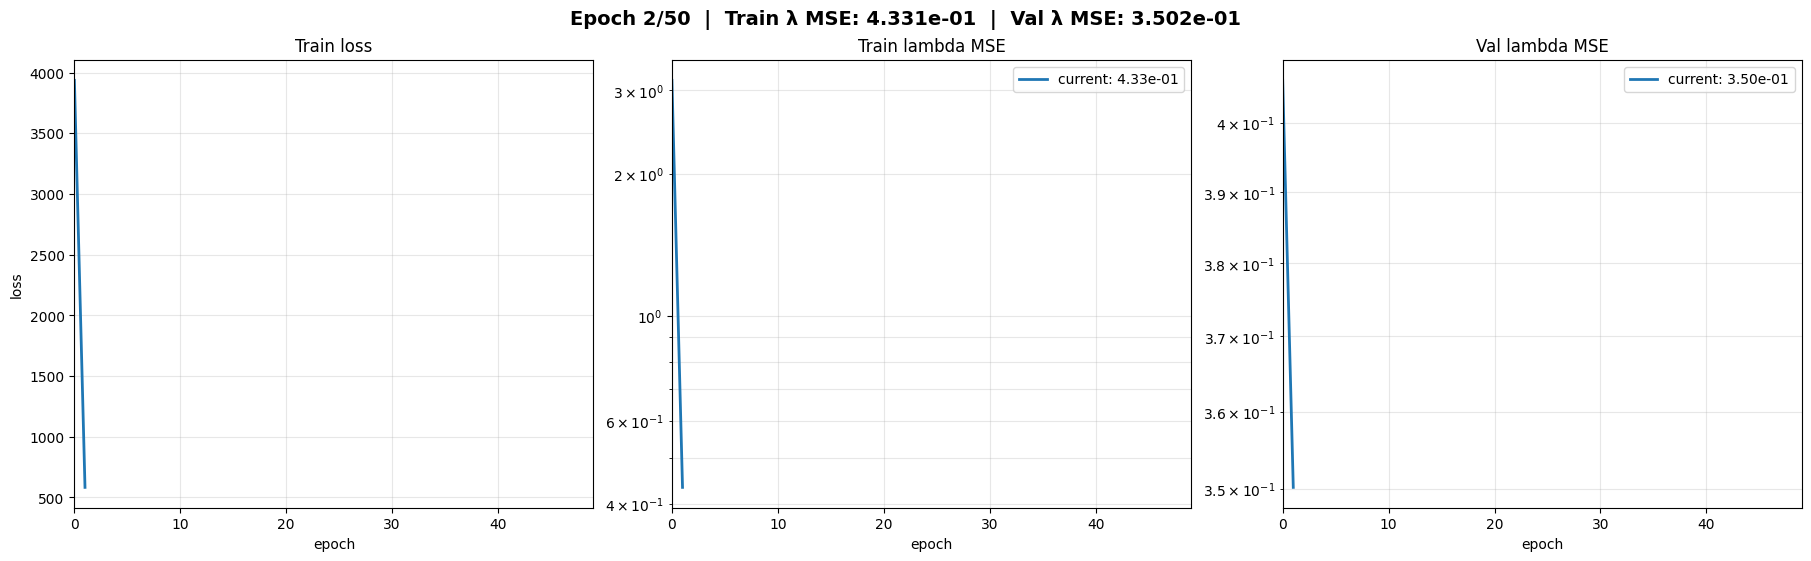

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

max_epochs = 50  # фиксируем горизонт оси X

train_dataset_with_embeddings = Embeddings(train_dataset, 16)
test_dataset_with_embeddings  = Embeddings(test_dataset, 16)

ref_model = HawkesModel(128, 1.0, 0.35, 0.7)
model = TransformerHawkes(16, 16)

batch_size = 100
train_dataloader = torch.utils.data.DataLoader(
    train_dataset_with_embeddings, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset_with_embeddings, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

losses, mse_lambdas, test_mse_lambdas = [], [], []

for epoch in range(max_epochs):
    clear_output(wait=True)

    train_loss, train_mse = train(model, ref_model, train_dataloader, optimizer, epoch)
    val_mse = test_lambda_mse(model, ref_model, test_dataloader)

    losses.append(float(train_loss))
    mse_lambdas.append(float(train_mse))
    test_mse_lambdas.append(float(val_mse))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), constrained_layout=True)
    fig.suptitle(
        f"Epoch {epoch+1}/{max_epochs}  |  Train λ MSE: {train_mse:.3e}  |  Val λ MSE: {val_mse:.3e}",
        fontsize=14, fontweight="bold"
    )

    # 1) Train loss
    axes[0].plot(losses, lw=2)
    axes[0].set_title("Train loss")
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")
    axes[0].set_xlim(0, max_epochs-1)
    axes[0].grid(True, which="both", alpha=0.3)

    # 2) Train λ MSE
    axes[1].plot(mse_lambdas, lw=2, label=f"current: {train_mse:.2e}")
    axes[1].set_title("Train lambda MSE")
    axes[1].set_xlabel("epoch")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, max_epochs-1)
    axes[1].grid(True, which="both", alpha=0.3)
    axes[1].legend(loc="upper right")

    # 3) Val λ MSE
    axes[2].plot(test_mse_lambdas, lw=2, label=f"current: {val_mse:.2e}")
    axes[2].set_title("Val lambda MSE")
    axes[2].set_xlabel("epoch")
    axes[2].set_yscale("log")
    axes[2].set_xlim(0, max_epochs-1)
    axes[2].grid(True, which="both", alpha=0.3)
    axes[2].legend(loc="upper right")

    plt.show()


#### Вопрос - что нужно поменять, чтобы мы могли работать с последовательностями из нескольких типов событий разной длины?

- Нам нужно добавить типы событий в датасет ```self.event_types```, проверить, что у нас нет событий типа 0, который мы будем использовать как padding, иначе сдвинуть типы событий (```self.event_types += 1```).
- Нужно добавить ```nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)``` и добавить выход из данного слоя к временному представлению.
- Нужно использовать zero padding с помощью функции ```torch.nn.functional.pad```, чтобы учесть последовательности разных времен в трансформере.
- Нужно изменить
```
self.alpha = Parameter(torch.ones(1))
self.w  = Parameter(torch.rand(M))
self.b = Parameter(torch.ones(1))
```
на
```
self.alpha = Parameter(torch.ones(n_types))
self.w  = Parameter(torch.rand(M,n_types))
self.b = Parameter(torch.ones(n_types))
```
и использовать соответствующую функцию интенсивности в $\sum \log \lambda_{c_i}(t_i)$


Вместо того, чтобы реализовывать данную модель руками, можно использовать следующую реализацию https://github.com/SimiaoZuo/Transformer-Hawkes-Process или
https://github.com/ant-research/EasyTemporalPointProcess

## Эксперименты с реальными данными

Для реальных примеров мы будем использовать модель Neural Hawkes.

### Neural Hawkes

https://github.com/xiao03/nh

### Загрузка данных

Прежде всего, мы должны загрузить данные, которые мы будем использовать для обучения.

In [ ]:
!pip install googledrivedownloader
from googledrivedownloader import download_file_from_google_drive

download_file_from_google_drive(file_id='0BwqmV0EcoUc8bllCOGJzVXNjSVk',
                                dest_path='./train.pkl')

In [ ]:
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '0BwqmV0EcoUc8bllCOGJzVXNjSVk'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

Это набор данных твитов с историей действий твитов. Давайте откроем файл.

In [ ]:
!pip install pickle-mixin --upgrade

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5988 sha256=ebbfc23b691bc7600c3b82f19443ff080d1a6654768ee396fb4f3f451cde10ac
  Stored in directory: /root/.cache/pip/wheels/d0/9c/0d/8709be17c02b72bf04ea60d8ec64fc46a1554c0fb81e048dd6
Successfully built pickle-mixin


In [ ]:
import pickle
with open('./train.pkl','rb') as f:
  train_dset = pickle.load(f, encoding='latin1')

In [ ]:
train_dset.keys()

dict_keys(['test1', 'args', 'dim_process', 'dev', 'train', 'test'])

In [ ]:
train_dset[b'train'][0]

[{b'time_since_start': 15.0, b'time_since_last_event': 15.0, b'type_event': 1},
 {b'time_since_start': 16.0, b'time_since_last_event': 1.0, b'type_event': 1},
 {b'time_since_start': 19.0, b'time_since_last_event': 3.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 4.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 0.0, b'type_event': 0},
 {b'time_since_start': 25.0, b'time_since_last_event': 2.0, b'type_event': 1},
 {b'time_since_start': 28.0, b'time_since_last_event': 3.0, b'type_event': 0},
 {b'time_since_start': 30.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 32.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 33.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 34.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 36.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 39.0, b'time_since_last_even

Здесь нам нужен только ключ  'train'; 'test', 'dev' и 'test1' пусты, эти данные в других файлах. Dev — это проверочный набор данных, мы его тоже загрузим.

Количество типов событий равно трем.

In [ ]:
train_dset[b'dim_process']

3

### Neural Hawkes

#### Функции утилит

`generate_sim_time_seqs` позволяет нам генерировать время для интегрального вычисления MC. Sim_index_seq — это вспомогательная последовательность для вычисления затухания скрытого состояния.

In [ ]:
import torch

def generate_sim_time_seqs(time_seqs, seqs_length):
    """Generate a simulated time interval sequences from original time interval sequences based on uniform distribution

    Args:
        time_seqs: list of torch float tensors
    Results:
        sim_time_seqs: list of torch float tensors
        sim_index_seqs: list of torch long tensors
    """
    sim_time_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).float()
    sim_index_seqs = torch.zeros((time_seqs.size()[0], time_seqs.size()[1]-1)).long()
    restore_time_seqs, restore_sim_time_seqs = [], []
    for idx, time_seq in enumerate(time_seqs):
        restore_time_seq = torch.stack([torch.sum(time_seq[0:i]) for i in range(1,seqs_length[idx]+1)])
        restore_sim_time_seq, _ = torch.sort(torch.empty(seqs_length[idx]-1).uniform_(0, restore_time_seq[-1]))

        sim_time_seq = torch.zeros(seqs_length[idx]-1)
        sim_index_seq = torch.zeros(seqs_length[idx]-1).long()

        for idx_t, t in enumerate(restore_time_seq):
            indices_to_update = restore_sim_time_seq > t

            sim_time_seq[indices_to_update] = restore_sim_time_seq[indices_to_update] - t
            sim_index_seq[indices_to_update] = idx_t

        restore_time_seqs.append(restore_time_seq)
        restore_sim_time_seqs.append(restore_sim_time_seq)
        sim_time_seqs[idx, :seqs_length[idx]-1] = sim_time_seq
        sim_index_seqs[idx, :seqs_length[idx]-1] = sim_index_seq

    return sim_time_seqs, sim_index_seqs

`pad_bos` функция позволяет дополнять последовательности, а также добавляет дополнительное нулевое событие, запускающее последовательность.

In [ ]:
def pad_bos(batch_data, type_size):
    event_seqs, time_seqs, total_time_seqs, seqs_length = batch_data
    pad_event_seqs = torch.zeros((event_seqs.size()[0], event_seqs.size()[1]+1)).long() * type_size
    pad_time_seqs = torch.zeros((time_seqs.size()[0], event_seqs.size()[1]+1)).float()

    pad_event_seqs[:, 1:] = event_seqs.clone()
    pad_event_seqs[:, 0] = type_size
    pad_time_seqs[:, 1:] = time_seqs.clone()

    return pad_event_seqs, pad_time_seqs, total_time_seqs, seqs_length

#### Датасет

In [ ]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

class CTLSTMDataset(Dataset):
    ''' Dataset class for neural hawkes data
    '''
    def __init__(self, file_path):
        self.file_path = file_path
        self.event_seqs = []
        self.time_seqs = []

        with open(self.file_path, 'rb') as f:
            if 'dev' in file_path:
                seqs = pickle.load(f)[b'dev']
            elif 'train' in file_path:
                seqs = pickle.load(f)[b'train'][:1000] # crop
            for idx, seq in enumerate(seqs):
                # if idx == 1:
                #     print(seq[0].keys())
                self.event_seqs.append(torch.LongTensor([int(event[b'type_event']) for event in seq]))
                self.time_seqs.append(torch.FloatTensor([float(event[b'time_since_last_event']) for event in seq]))

    def __len__(self):
        return len(self.event_seqs)

    def __getitem__(self, index):
        sample = {
            'event_seq': self.event_seqs[index],
            'time_seq': self.time_seqs[index]
        }

        return sample

def pad_batch_fn(batch_data):
    sorted_batch = sorted(batch_data, key=lambda x: x['event_seq'].size(), reverse=True)
    event_seqs = [seq['event_seq'].long() for seq in sorted_batch]
    time_seqs = [seq['time_seq'].float() for seq in sorted_batch]
    seqs_length = torch.LongTensor(list(map(len, event_seqs)))
    last_time_seqs = torch.stack([torch.sum(time_seq) for time_seq in time_seqs])

    event_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).long()
    time_seqs_tensor = torch.zeros(len(sorted_batch), seqs_length.max()).float()

    for idx, (event_seq, time_seq, seqlen) in enumerate(zip(event_seqs, time_seqs, seqs_length)):
        event_seqs_tensor[idx, :seqlen] = torch.LongTensor(event_seq)
        time_seqs_tensor[idx, :seqlen] = torch.FloatTensor(time_seq)

    return event_seqs_tensor, time_seqs_tensor, last_time_seqs, seqs_length

#### Модель

In [ ]:
"""A continuous time LSTM network."""
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader


class CTLSTM(nn.Module):
    """Continuous time LSTM network with decay function."""
    def __init__(self, hidden_size, type_size, batch_first=True):
        super(CTLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.type_size = type_size
        self.batch_first = batch_first
        self.num_layers = 1

        # Parameters
        # recurrent cells
        self.rec = nn.Linear(2*self.hidden_size, 7*self.hidden_size)
        # output mapping from hidden vectors to unnormalized intensity
        self.wa = nn.Linear(self.hidden_size, self.type_size)
        # embedding layer for valid events, including BOS
        self.emb = nn.Embedding(self.type_size+1, self.hidden_size)

    def init_states(self, batch_size):
        self.h_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_d = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c_bar = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)
        self.c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float)

    def recurrence(self, emb_event_t, h_d_tm1, c_tm1, c_bar_tm1):
        feed = torch.cat((emb_event_t, h_d_tm1), dim=1)
        # B * 2H
        (gate_i,
        gate_f,
        gate_z,
        gate_o,
        gate_i_bar,
        gate_f_bar,
        gate_delta) = torch.chunk(self.rec(feed), 7, -1)

        gate_i = torch.sigmoid(gate_i)
        gate_f = torch.sigmoid(gate_f)
        gate_z = torch.tanh(gate_z)
        gate_o = torch.sigmoid(gate_o)
        gate_i_bar = torch.sigmoid(gate_i_bar)
        gate_f_bar = torch.sigmoid(gate_f_bar)
        gate_delta = F.softplus(gate_delta)

        c_t = gate_f * c_tm1 + gate_i * gate_z
        c_bar_t = gate_f_bar * c_bar_tm1 + gate_i_bar * gate_z

        return c_t, c_bar_t, gate_o, gate_delta

    def decay(self, c_t, c_bar_t, o_t, delta_t, duration_t):
        c_d_t = c_bar_t + (c_t - c_bar_t) * \
            torch.exp(-delta_t * duration_t.view(-1,1))

        h_d_t = o_t * torch.tanh(c_d_t)

        return c_d_t, h_d_t

    def forward(self, event_seqs, duration_seqs, batch_first = True):
        if batch_first:
            event_seqs = event_seqs.transpose(0,1)
            duration_seqs = duration_seqs.transpose(0,1)

        batch_size = event_seqs.size()[1]
        batch_length = event_seqs.size()[0]

        h_list, c_list, c_bar_list, o_list, delta_list = [], [], [], [], []
        self.init_states(batch_size)
        for t in range(batch_length):
            c, self.c_bar, o_t, delta_t = self.recurrence(self.emb(event_seqs[t]), self.h_d, self.c_d, self.c_bar)
            self.c_d, self.h_d = self.decay(c, self.c_bar, o_t, delta_t, duration_seqs[t])
            h_list.append(self.h_d)
            c_list.append(c)
            c_bar_list.append(self.c_bar)
            o_list.append(o_t)
            delta_list.append(delta_t)
        h_seq = torch.stack(h_list)
        c_seq = torch.stack(c_list)
        c_bar_seq = torch.stack(c_bar_list)
        o_seq = torch.stack(o_list)
        delta_seq = torch.stack(delta_list)

        self.output = torch.stack((h_seq, c_seq, c_bar_seq, o_seq, delta_seq))
        return self.output

    def log_likelihood(self, event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length, batch_first=True):
        """Calculate log likelihood per sequence."""
        batch_size, batch_length = event_seqs.shape
        h, c, c_bar, o, delta = torch.chunk(self.output, 5, 0)
        # L * B * H
        h = torch.squeeze(h, 0)
        c = torch.squeeze(c, 0)
        c_bar = torch.squeeze(c_bar, 0)
        o = torch.squeeze(o, 0)
        delta = torch.squeeze(delta, 0)

        # Calculate the sum of log intensities of each event in the sequence
        original_loglikelihood = torch.zeros(batch_size)
        lambda_k = F.softplus(self.wa(h)).transpose(0, 1)

        for idx, (event_seq, seq_len) in enumerate(zip(event_seqs, seqs_length)):
            original_loglikelihood[idx] = torch.sum(torch.log(
                                                     lambda_k[idx, torch.arange(seq_len).long(), event_seq[1:seq_len+1]]))

        # Calculate simulated loss from MCMC method
        h_d_list = []
        if batch_first:
            sim_time_seqs = sim_time_seqs.transpose(0,1)
        for idx, sim_duration in enumerate(sim_time_seqs):
            _, h_d_idx = self.decay(c[idx], c_bar[idx], o[idx], delta[idx], sim_duration)
            h_d_list.append(h_d_idx)
        h_d = torch.stack(h_d_list)

        sim_lambda_k = F.softplus(self.wa(h_d)).transpose(0,1)
        simulated_likelihood = torch.zeros(batch_size)
        for idx, (total_time, seq_len) in enumerate(zip(total_time_seqs, seqs_length)):
            mc_coefficient = total_time / (seq_len)
            simulated_likelihood[idx] = mc_coefficient * torch.sum(torch.sum(sim_lambda_k[idx, torch.arange(seq_len).long(), :]))

        loglikelihood = torch.sum(original_loglikelihood - simulated_likelihood)
        return loglikelihood

#### Обучение

In [ ]:
import time
import datetime
import torch
import torch.optim as opt
from torch.utils.data import DataLoader

def train(hidden_size, type_size, train_path, batch_size, epoch_num, current_date):
    """Training process."""
    model = CTLSTM(hidden_size, type_size)
    optim = opt.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 10, 0.5)
    train_dataset = CTLSTMDataset(train_path)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_batch_fn, shuffle=True)

    last_dev_loss = 0.0
    for epoch in range(epoch_num):
        tic_epoch = time.time()
        epoch_train_loss = 0.0
        epoch_dev_loss = 0.0
        train_event_num = 0
        dev_event_num = 0
        print('Epoch.{} starts.'.format(epoch))
        tic_train = time.time()
        for i_batch, sample_batched in enumerate(train_dataloader):
            tic_batch = time.time()

            optim.zero_grad()

            event_seqs, time_seqs, total_time_seqs, seqs_length = pad_bos(sample_batched, model.type_size)

            sim_time_seqs, sim_index_seqs = generate_sim_time_seqs(time_seqs, seqs_length)

            model.forward(event_seqs, time_seqs)
            likelihood = model.log_likelihood(event_seqs, sim_time_seqs, sim_index_seqs, total_time_seqs, seqs_length)
            batch_event_num = torch.sum(seqs_length)
            batch_loss = -likelihood

            batch_loss.backward()
            optim.step()
            scheduler.step()

            toc_batch = time.time()
            if i_batch % 1 == 0:
                print('Epoch.{} Batch.{}:\nBatch Likelihood per event: {:5f} nats\nTrain Time: {:2f} s'.format(epoch, i_batch, likelihood/batch_event_num, toc_batch-tic_batch))
            epoch_train_loss += batch_loss
            train_event_num += batch_event_num

        toc_train = time.time()
        print('---\nEpoch.{} Training set\nTrain Likelihood per event: {:5f} nats\nTrainig Time:{:2f} s'.format(epoch, -epoch_train_loss/train_event_num, toc_train-tic_train))

    return

In [ ]:
train(128, 3, './train.pkl' ,100, 10, '28.03.2022')

Epoch.0 starts.
Epoch.0 Batch.0:
Batch Likelihood per event: -5194.777344 nats
Train Time: 7.258365 s
Epoch.0 Batch.1:
Batch Likelihood per event: -4599.017578 nats
Train Time: 4.367969 s
Epoch.0 Batch.2:
Batch Likelihood per event: -3644.190430 nats
Train Time: 4.461688 s
Epoch.0 Batch.3:
Batch Likelihood per event: -2950.999268 nats
Train Time: 7.544198 s
Epoch.0 Batch.4:
Batch Likelihood per event: -3471.432617 nats
Train Time: 7.356628 s
Epoch.0 Batch.5:
Batch Likelihood per event: -2354.091553 nats
Train Time: 5.064442 s
Epoch.0 Batch.6:
Batch Likelihood per event: -2011.102905 nats
Train Time: 5.258351 s
Epoch.0 Batch.7:
Batch Likelihood per event: -1448.854980 nats
Train Time: 6.052946 s
